In [2]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import seaborn.objects as so
import numpy as np
import warnings

score_order = [
    'activations-que', 
    'activations-mahalanobis', 
    'activations-lof', 
    # 'activations-isoforest', 
    # 'activations-likelihood',
    # 'activations-em',
    # 'activations-pca-mahalanobis',
    # 'activations-mahalanobis-mlp_out',
    # 'activations-mahalanobis\nStandard',
    # 'activations-mahalanobis\nCarmon2019Unlabeled',
    # 'activations-que\nStandard',
    # 'activations-que\nCarmon2019Unlabeled',
    # 'attribution-mahalanobis\nStandard',
    # 'attribution-mahalanobis\nCarmon2019Unlabeled',
    # 'attribution-que\nStandard',
    # 'attribution-que\nCarmon2019Unlabeled',
    'attribution-mahalanobis\nmean',
    # 'attribution-mahalanobis\npcs',
    # 'attribution-mahalanobis\nraw',
    # 'attribution-mahalanobis\ngrad_norm',
    # 'attribution-que\nmean', 
    # 'attribution-que\npcs',
    # 'attribution-que\nraw',
    # 'attribution-que\ngrad_norm',
    'attribution-lof\nmean',
    # 'attribution-lof\npcs',
    # 'attribution-lof\nraw',
    # 'attribution-lof\ngrad_norm',
    # 'attribution-isoforest\nmean',
    # 'attribution-isoforest\npcs',
    # 'attribution-isoforest\nraw',
    # 'attribution-isoforest\ngrad_norm',
    # 'attribution-mahalanobis\nconcat-mean',
    # 'attribution-que\nconcat-mean',
    # 'attribution_activations-mahalanobis\nmean',
    # 'attribution_activations-mahalanobis\nmean-ensemble',
    # 'attribution_activations-mahalanobis\npcs',
    # 'attribution_activations-mahalanobis\nraw',
    # 'attribution_activations-mahalanobis\ngrad_norm',
    'probe-mahalanobis\nmean',
    # 'probe-que\nmean',
    # 'probe-mahalanobis\npcs',
    # 'probe-que\npcs',
    'probe-lof\nmean',
    # 'probe-lof\npcs',
    # 'probe-isoforest\nmean',
    # 'probe-isoforest\npcs',
    # 'probe-isoforest\nraw',
    # 'probe-isoforest\ngrad_norm',
    # 'probe-mahalanobis\nconcat-mean',
    # 'probe-que\nconcat-mean',
    # 'probe-lof\nconcat-mean',
    # 'probe-lof\nconcat-pcs',
    # 'probe_activations-mahalanobis\nmean',
    # 'probe_activations-mahalanobis\nmean-ensemble',
    # 'rephrase', 
    # 'misconception',
    'flow-mahalanobis',
    'flow-laplace',
    'sae-diag-mahalanobis',
    'sae-l0'

]

score_order = ['mistral-' + i for i in score_order] + ['meta-' + i for i in score_order]

score_order.remove('mistral-flow-laplace')

online_score_order = [i for i in score_order if not any([j in i for j in ['likelihood', 'que', '-em']])]
offline_score_order = [i for i in score_order if any([j in i for j in ['likelihood', 'que', '-em']])]

# Define the path to the logs directory
logs_dir = '../logs/quirky'
mart_logs_dir = '../logs/mart_logs/quirky/pca_results_hard'
image_dir = '../logs/adv_image'
base_model_dict = {
    'mistral': 'Mistral-7B-v0.1',
    'meta': 'Meta-Llama-3.1-8B'
}

def safe_logprob_to_logit(logprob, name):
    try:
        logit = -logprob - np.log1p(-np.exp(-logprob))
        if np.isinf(logit) or np.isnan(logit):
            warnings.warn(f"Warning: {name} is {'infinite' if np.isinf(logit) else 'NaN'}")
            return np.nan
        return logit
    except Exception as e:
        warnings.warn(f"Error converting {name}: {str(e)}")
        return np.nan

def get_basename_or_parent(path):
    basename = os.path.basename(path)
    if basename.split('-')[0] != 'all':
        return basename
    else:
        # If basename is empty, get the parent directory's basename
        parent_path = os.path.dirname(path)
        return os.path.basename(parent_path)

def get_layer(layer_tag):
    if layer_tag == 'all':
        return -1
    elif layer_tag == 'out':
        return 32
    # elif len(re.findall(r'\d+', layer_tag)) == 1:
    #     return 10
    else:
        return int(re.findall(r'\d+', layer_tag)[0])
        # return int(re.findall(r'\d+', layer_tag)[0])*3 + int(re.findall(r'\d+', layer_tag)[1])

filters = {
    'rand_vs_nonrand': lambda root, dirs, files: 'eval.json' in files and 'probe_trajectory' in get_basename_or_parent(root) and
     ('-rand_retrain' in get_basename_or_parent(root) or 'nrand_retrain2' in get_basename_or_parent(root) or '--' in get_basename_or_parent(root)),
    'layerwise_activations': lambda root, dirs, files: 'eval.json' in files and len(get_basename_or_parent(root).split('-')) > 4 and 'activations' in get_basename_or_parent(root),
    'layerwise_agnostic': lambda root, dirs, files: 'eval.json' in files and len(get_basename_or_parent(root).split('-')) > 4 
     and# 'capitals' not in root and 'authors' not in root and
    ('activations' in root or 'iterative_rephrase' in root or 'attribution' in root or 'probe' in root or 'misconception' in root or 'nflow' in root or 'sae' in root),
    'none': lambda root, dirs, files: 'eval.json' in files
}
def get_data(filter, train_from_test=False, log_dir=logs_dir, score_order = online_score_order):
    results = []
    for root, dirs, files in os.walk(log_dir):
        if filter(root, dirs, files):
            # Load the main eval.json
            main_eval_path = os.path.join(root, 'eval.json')
            with open(main_eval_path, 'r') as f:
                main_eval = json.load(f)
            if 'probe' in root and ('Mistral' not in root and 'Meta' not in root):
                continue
            
            if 'attribution_activations' in root and 'Mistral' in root:
                continue
            
            # if 'attribution-' in root and 'Mistral' not in root:
            #     continue

            # Extract dataset name from the folder structure
            base_model = 'mistral'
            if 'Meta' in root:
                base_model = 'meta'
            name_parts = get_basename_or_parent(root).split('-')
            dataset = name_parts[0]
            score = name_parts[1]
            features = None
            alpha = None
            layer = None
            if len(name_parts) > 2:
                features = name_parts[2]
                features = features.replace('activations_attribution', 'attribution_activations')

            if name_parts[-1].isdigit():
                alpha = int(name_parts[-1])
            rand = 0 if 'nrand' in get_basename_or_parent(root) else 1
             
            # score = features + '-' + score
            if features.split('_')[0] == 'attribution':
                if 'refactor' not in root:
                    score = features + '-' + score + '\n' + name_parts[-1]
                else:
                    score = features + '-' + score + '\n' + name_parts[-1]
            if features.split('_')[0] == 'probe':
                score = features + '-' + score + '\n' + name_parts[-1]
            if features.split('_')[0] == 'activations':
                score = features + '-' + score
            if 'nflow' in root:
                score = 'flow-' + score
            if 'misconception' in root:
                score = 'misconception'
            if 'rephrase' in root:
                score = 'rephrase'
            if name_parts[-1] == 'concat':
                score += f'-{name_parts[-2]}'
            if 'ensemble' in root:
                score += '-ensemble'
            if 'cifar10' in root:
                score += f'\n{name_parts[3]}'
            if 'mlp_out' in root:
                score += '-mlp_out'
            if 'sae' in root:
                if 'scaled_mean_diff' in root:
                    score = 'sae-diag-mahalanobis'
                if 'l0' in root:
                    score = 'sae-l0'
            score = f'{base_model}-' + score

            for key, value in main_eval.items():
                layer = get_layer(key)
                results.append({
                    'alpha': alpha,
                    'dataset': dataset,
                    'score': score,
                    'features': features,
                    'layer': layer,
                    'random_names': rand,
                    'auc_roc': value['AUC_ROC'],
                    'auc_roc_agree': value['AUC_ROC_AGREE'],
                    'auc_roc_disagree': value['AUC_ROC_DISAGREE'],
                    'base_model': base_model
                })

        # Create a DataFrame from the results
    df = pd.DataFrame(results)
    
    # Load accuracy data and compute quirky_coefficient
    accuracy_data = []
    accuracy_dir = '../logs/quirky/accuracy'
    for dataset in df['dataset'].unique():
        for base_model in df['base_model'].unique():
            base_model_path = base_model_dict[base_model]
            accuracy_file = os.path.join(accuracy_dir, f"{dataset}_{base_model_path}", "eval.json")
            if os.path.exists(accuracy_file):
                with open(accuracy_file, 'r') as f:
                    acc_data = json.load(f)
                length = min(len(acc_data['Bob_GT_Loss_Disagree']), len(acc_data['Alice_Wrong_Label_Loss_Disagree']))
                for i in range(length):

                    alice_logits_disagree = safe_logprob_to_logit(acc_data['Alice_GT_Loss_Disagree'][i], "alice_logits_disagree")
                    bob_logits_disagree = safe_logprob_to_logit(acc_data['Bob_Loss_Disagree'][i], "bob_logits_disagree")
                    alice_bob_logits_disagree = safe_logprob_to_logit(acc_data['Alice_Wrong_Label_Loss_Disagree'][i], "alice_bob_logits_disagree")
                    bob_alice_logits_disagree = safe_logprob_to_logit(acc_data['Bob_GT_Loss_Disagree'][i], "bob_alice_logits_disagree")


                    if any([np.isnan(alice_logits_disagree), np.isnan(bob_logits_disagree), np.isnan(alice_bob_logits_disagree), np.isnan(bob_alice_logits_disagree)]):
                        continue

                    quirky_coefficient = np.mean([(alice_logits_disagree - bob_alice_logits_disagree), 
                        (bob_logits_disagree - alice_bob_logits_disagree)])
                    
                    accuracy_data.append({
                        'dataset': dataset,
                        'base_model': base_model,
                        'quirky_coefficient': quirky_coefficient,
                        'bob_gt_logits_disagree': bob_alice_logits_disagree,
                        'alice_wrong_label_logits_disagree': alice_bob_logits_disagree,
                        'alice_gt_logits_disagree': alice_logits_disagree,
                        'bob_logits_disagree': bob_logits_disagree,
                        'alice_loss': acc_data['Alice_Loss'][i],
                        'bob_loss': acc_data['Bob_Loss'][i]
                    })
    
    accuracy_df = pd.DataFrame(accuracy_data)
    accdf_grouped = accuracy_df.groupby(['dataset', 'base_model']).agg({
        'bob_gt_logits_disagree': lambda x: np.nanmean(x),
        'alice_wrong_label_logits_disagree': lambda x: np.nanmean(x),
        'alice_gt_logits_disagree': lambda x: np.nanmean(x),
        'bob_logits_disagree': lambda x: np.nanmean(x),
        'quirky_coefficient': lambda x: np.nanmean(x),
    }).reset_index()
    df = df.merge(accdf_grouped, on=['dataset', 'base_model'], how='left')

    # Order the datasets
    dataset_order = [
        # 'capitals',
        # 'authors',
        'population', 
        'nli', 
        # 'sciq', 
        'sentiment',  
        'hemisphere',  
        'addition', 
        'subtraction', 
        'multiplication', 
        'modularaddition', 
        'squaring'
    ]
    base_model_order = [
        'mistral',
        'meta'
    ]
    df['score'] = pd.Categorical(df['score'], categories=score_order, ordered=True)
    df['dataset'] = pd.Categorical(df['dataset'], categories=dataset_order, ordered=True)
    df['base_model'] = pd.Categorical(df['base_model'], categories=base_model_order, ordered=True)
    df = df.drop_duplicates(subset=['dataset', 'score', 'layer', 'base_model'])

    # Load and process variance ratio files
    variance_dfs = []
    for base_model, model_name in base_model_dict.items():
        variance_file = f'../plots/variances/{model_name}/variance_ratios.csv'
        if os.path.exists(variance_file):
            var_df = pd.read_csv(variance_file)
            var_df['base_model'] = base_model
            var_df['layer'] = var_df['layer'].apply(lambda x: int(x.split('.')[-3]))
            var_df['variance_ratio'] = var_df['variance_ratio'].apply(lambda x: float(x.split(',')[0].split('(')[-1]))
            var_df['variance_ratio'] = var_df['variance_ratio'].apply(lambda x: 0 if x < 0 else min(x, 10000))
            variance_dfs.append(var_df)

    if variance_dfs:
        variance_df = pd.concat(variance_dfs)
        
        # Merge variance ratios with the main dataframe
        df = df.merge(variance_df[['base_model', 'dataset', 'layer', 'variance_ratio']], 
                      on=['base_model', 'dataset', 'layer'], 
                      how='left')


        min_var_df = variance_df.groupby(['base_model', 'dataset']).agg({'variance_ratio': 'min'}).reset_index()
        accuracy_df = accuracy_df.merge(min_var_df, on=['base_model', 'dataset'], how='left')
    
    df['score'] = pd.Categorical(df['score'], categories=score_order, ordered=True)
    df['dataset'] = pd.Categorical(df['dataset'], categories=dataset_order, ordered=True)
    df['base_model'] = pd.Categorical(df['base_model'], categories=base_model_order, ordered=True)

    return df, accuracy_df

def barplot_by_dataset(df, compare='random_names', disagree=False):
    if disagree:
        y_col = 'auc_roc_disagree'
        title = f'Mean AUC-ROC by Dataset and {compare} (only where Alice/Bob disagree)'
    else:
        y_col = 'auc_roc'
        title = f'Mean AUC-ROC by Dataset and {compare}'
    grouped_df = df.groupby(['dataset', compare])[y_col].mean().reset_index()
    grouped_df = grouped_df.sort_values(by='dataset', ascending=True)
    # Create the barplot
    plt.figure(figsize=(12, 6))
    sns.barplot(x='dataset', y=y_col, hue=compare, data=grouped_df)

    plt.title(title)
    plt.xlabel('Dataset')
    plt.ylabel('Alice vs Bob AUC')
    plt.legend(title=compare)
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

metrics_dict = {
    'auc_roc': 'Alice vs Bob AUC',
    'auc_roc_agree': 'Alice vs Bob AUC (Agree)',
    'auc_roc_disagree': 'Alice vs Bob AUC (Disagree)',
    'auc_roc_train_from_test_all': 'Train names vs Test names AUC',
    'auc_roc_train_from_test_agree': 'Train names vs Test names AUC (Agree)',
    'auc_roc_train_from_test_disagree': 'Train names vs Test names AUC (Disagree)'
    }

def plot_auc_roc_by_layer_by_score(
        df, 
        multilayer=True,
        disagree=False):
    df['layer']=df['layer'].astype(int)
    df = df[df['score'].isin(score_order)]

    if disagree:
        y_col = 'auc_roc_disagree'
        title = '{} (disagree only)'
    else:
        y_col = 'auc_roc'
        title = '{} (all examples)'

    if multilayer:
        df = df[df['layer'] >= 0]
        df['score'] = df['score'].cat.remove_unused_categories()
        df['title'] = df['score'].astype(str) + ' ' + title
        df = df.sort_values(by=['dataset', 'layer', 'base_model'])
        g = (
            so.Plot(df, x="layer", y=y_col, color="dataset", marker="dataset")
            .facet(col="score", wrap=3)
            .add(so.Line(), so.Agg(), so.Jitter(x=2))
            .label(x="Layer", y=metrics_dict[y_col], title=title.format)
            .theme({
                "figure.figsize": (12, 4*(len(df['score'].unique()) + 3)//3),
            })
        )
    else:
        df = df[df['layer'] < 0]
        df['score'] = df['score'].cat.remove_unused_categories()
        
        fig, ax = plt.subplots(1,1, figsize=(20, 12))  # Increased figure size
        plot_df = df.sort_values(by=['dataset', 'layer'])
        
        g = sns.barplot(data=plot_df, x="score", y="auc_roc", ax=ax, hue="dataset", dodge=True)

        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
        ax.axhline(y=0.5, color='gray', linestyle='--', alpha=0.7)
        ax.set_ylim(df['auc_roc'].min()*0.9, 1.03)
        ax.set_xlabel(None)
        ax.set_title('AUC-ROC by Dataset for Different Scores')


    plt.tight_layout()
    plt.show()

    return g


/tmp/ipykernel_2723118/1099315873.py:117: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_df = df.groupby(['dataset', compare])[y_col].mean().reset_index()


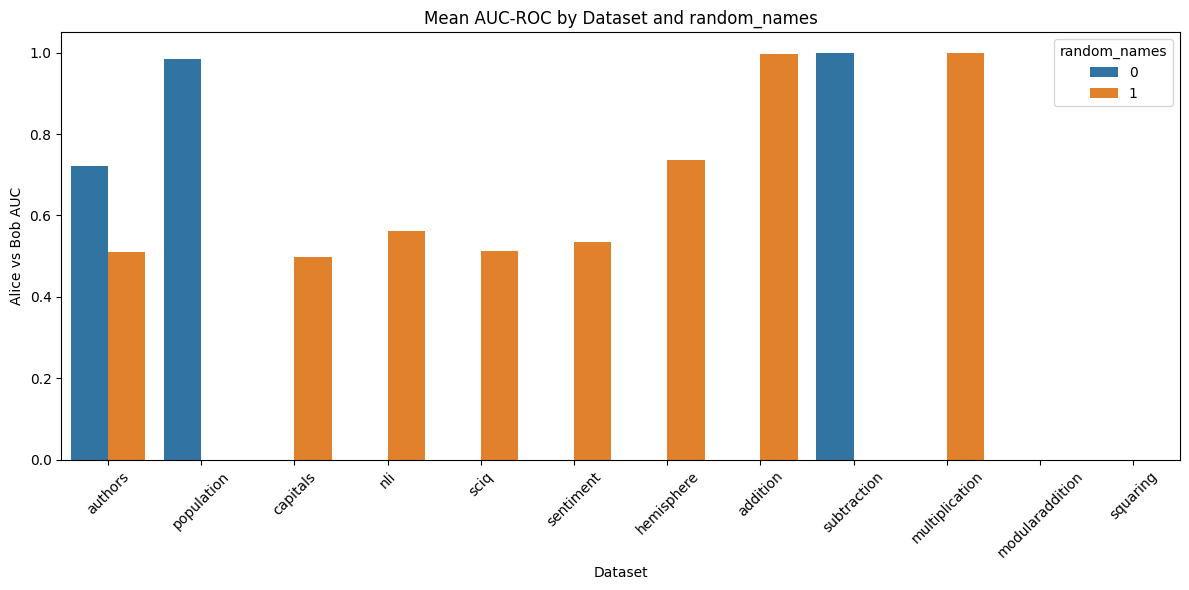

In [2]:
df = get_data(filters['rand_vs_nonrand'])
barplot_by_dataset(df[~df['dataset'].isin(['modularaddition', 'squaring'])], compare='random_names')

Automatic pdb calling has been turned ON


/tmp/ipykernel_3897959/3044620392.py:94: RuntimeWarning: divide by zero encountered in log1p
  logit = -logprob - np.log1p(-np.exp(-logprob))
/tmp/ipykernel_3897959/3044620392.py:96: UserWarning: Warning: alice_logits_disagree is infinite
  warnings.warn(f"Warning: {name} is {'infinite' if np.isinf(logit) else 'NaN'}")
/tmp/ipykernel_3897959/3044620392.py:96: UserWarning: Warning: bob_logits_disagree is infinite
  warnings.warn(f"Warning: {name} is {'infinite' if np.isinf(logit) else 'NaN'}")
/tmp/ipykernel_3897959/3044620392.py:96: UserWarning: Warning: alice_bob_logits_disagree is infinite
  warnings.warn(f"Warning: {name} is {'infinite' if np.isinf(logit) else 'NaN'}")
/tmp/ipykernel_3897959/3044620392.py:96: UserWarning: Warning: bob_alice_logits_disagree is infinite
  warnings.warn(f"Warning: {name} is {'infinite' if np.isinf(logit) else 'NaN'}")


<Figure size 640x480 with 0 Axes>

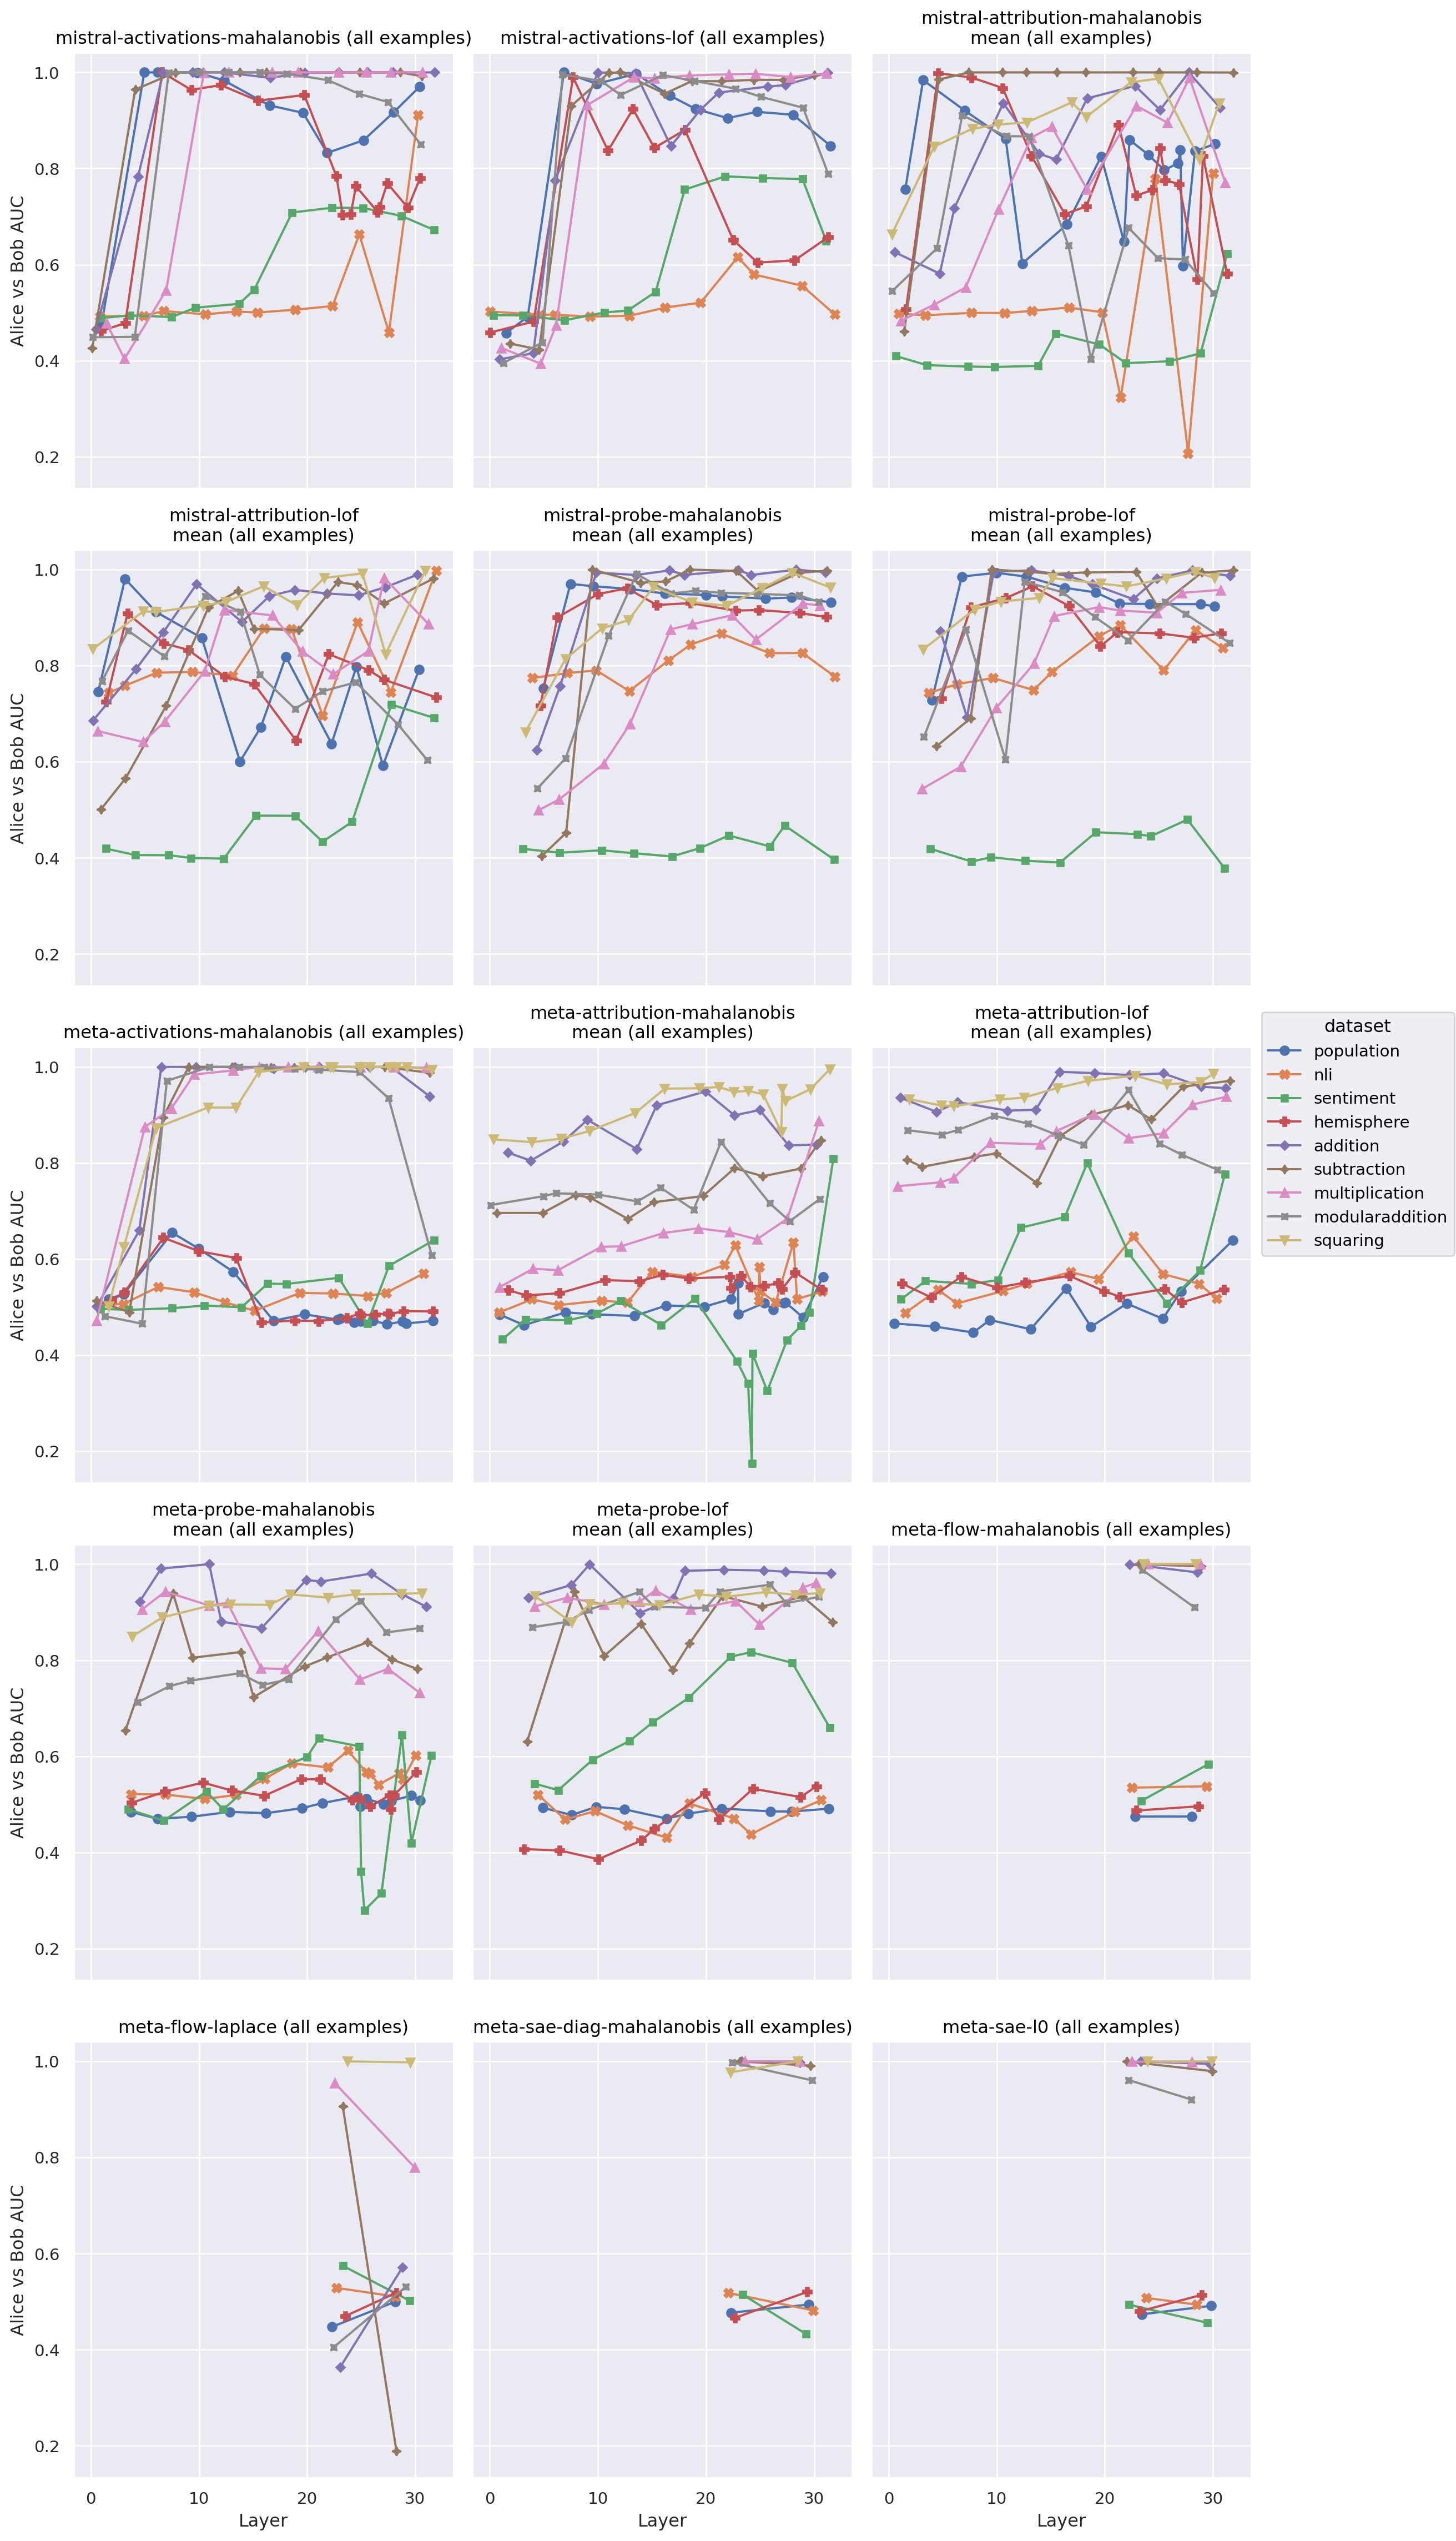

In [3]:
%pdb on
df, accuracy_df = get_data(filters['layerwise_agnostic'])
df.loc[df['score'].isin(['rephrase']), 'layer'] = -1
df = df.sort_values(by=['dataset', 'score', 'layer'])
plot_auc_roc_by_layer_by_score(df)

/tmp/ipykernel_3897959/3044620392.py:94: RuntimeWarning: divide by zero encountered in log1p
  logit = -logprob - np.log1p(-np.exp(-logprob))
/tmp/ipykernel_3897959/3044620392.py:96: UserWarning: Warning: alice_logits_disagree is infinite
  warnings.warn(f"Warning: {name} is {'infinite' if np.isinf(logit) else 'NaN'}")
/tmp/ipykernel_3897959/3044620392.py:96: UserWarning: Warning: bob_logits_disagree is infinite
  warnings.warn(f"Warning: {name} is {'infinite' if np.isinf(logit) else 'NaN'}")
/tmp/ipykernel_3897959/3044620392.py:96: UserWarning: Warning: alice_bob_logits_disagree is infinite
  warnings.warn(f"Warning: {name} is {'infinite' if np.isinf(logit) else 'NaN'}")
/tmp/ipykernel_3897959/3044620392.py:96: UserWarning: Warning: bob_alice_logits_disagree is infinite
  warnings.warn(f"Warning: {name} is {'infinite' if np.isinf(logit) else 'NaN'}")


<Figure size 640x480 with 0 Axes>

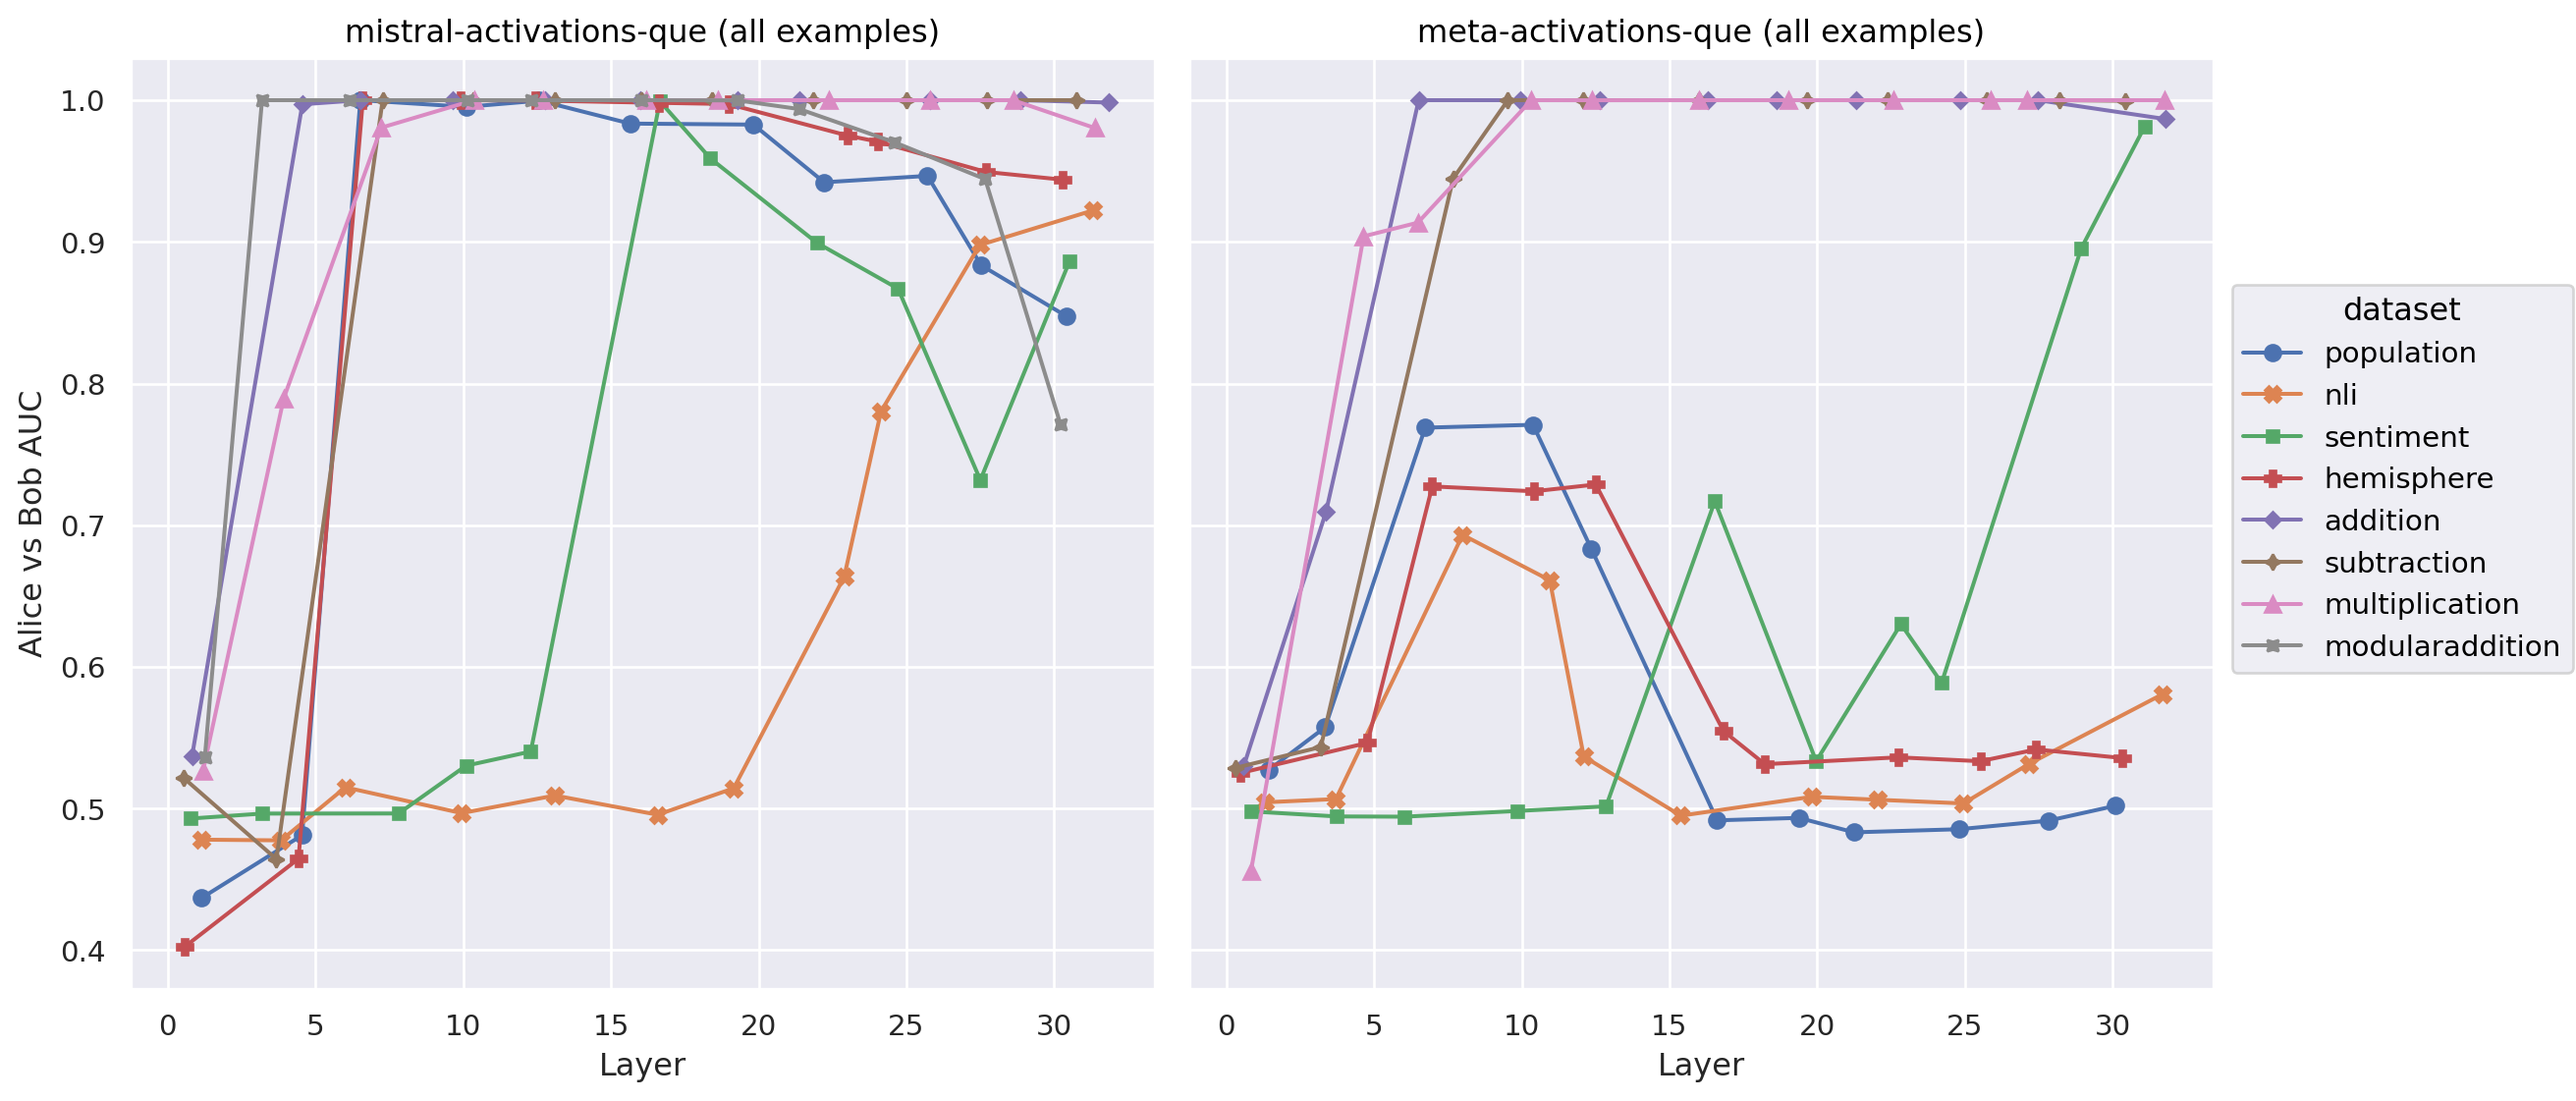

In [9]:
df, accuracy_df = get_data(filters['layerwise_agnostic'], score_order=offline_score_order)
plot_auc_roc_by_layer_by_score(df)

/tmp/ipykernel_3897959/3044620392.py:385: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


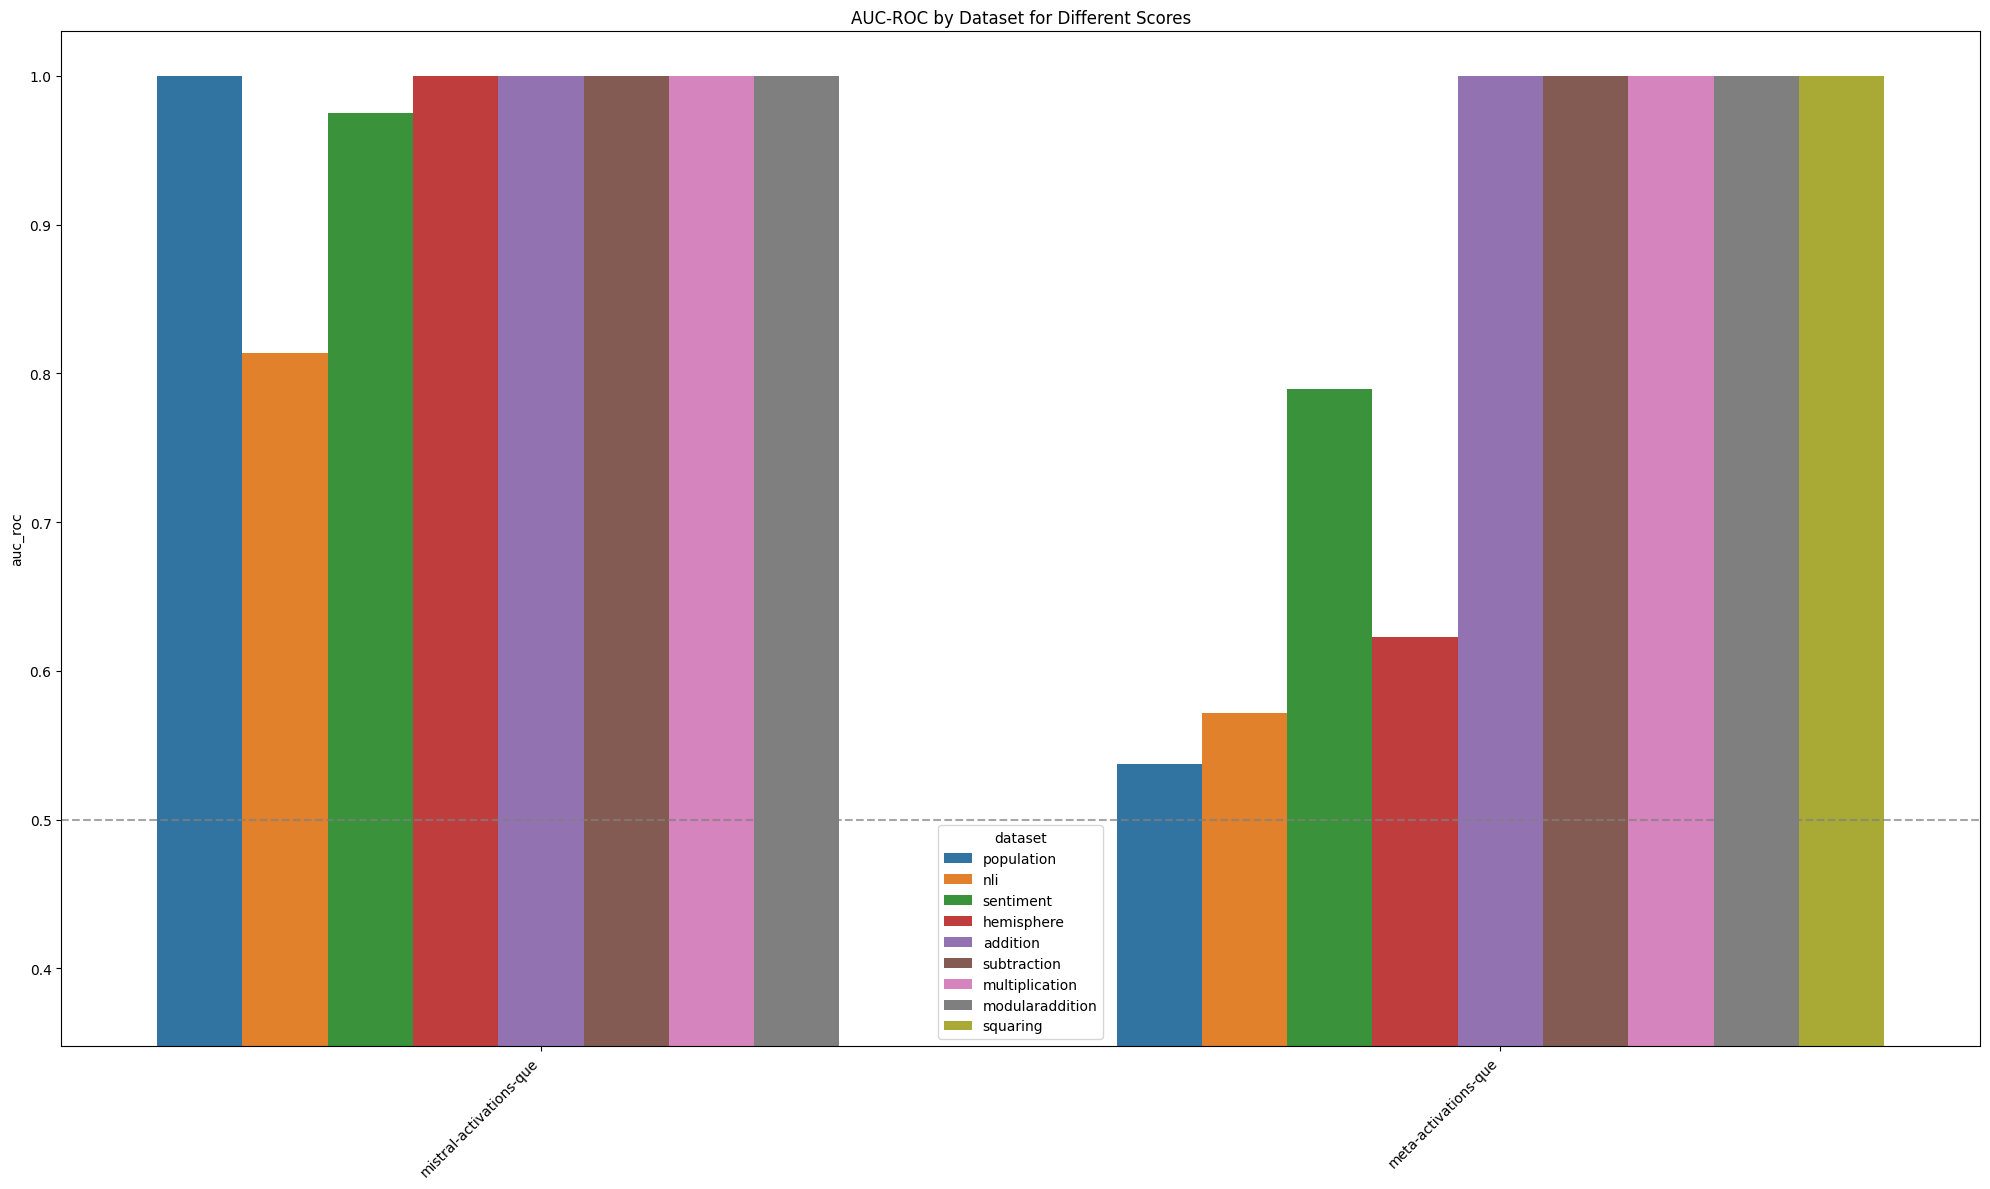

<Axes: title={'center': 'AUC-ROC by Dataset for Different Scores'}, ylabel='auc_roc'>

In [10]:
plot_auc_roc_by_layer_by_score(df, multilayer=False)

In [8]:
df

(     alpha          dataset                    score     features  layer  \
 0      NaN              NaN                      NaN        probe      4   
 1      NaN              NaN                      NaN        probe      7   
 2      NaN              NaN                      NaN        probe     10   
 3      NaN              NaN                      NaN        probe     13   
 4      NaN              NaN                      NaN        probe     16   
 ..     ...              ...                      ...          ...    ...   
 529    4.0  modularaddition  mistral-activations-que  activations     22   
 530    4.0  modularaddition  mistral-activations-que  activations     25   
 531    4.0  modularaddition  mistral-activations-que  activations     28   
 532    4.0  modularaddition  mistral-activations-que  activations     31   
 533    NaN   multiplication  mistral-activations-que  activations     -1   
 
      random_names   auc_roc  auc_roc_agree  auc_roc_disagree base_model  

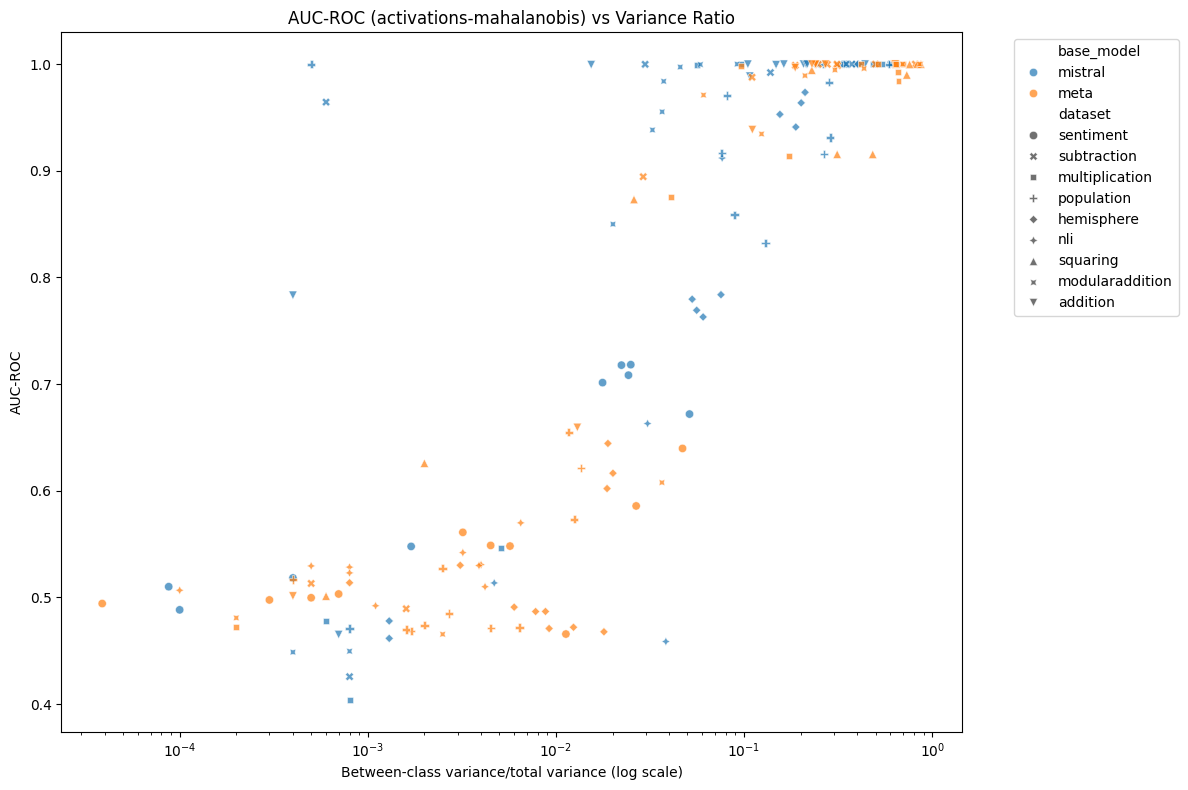

In [12]:
filtered_df = df[df['score'].isin(['mistral-activations-mahalanobis', 'meta-activations-mahalanobis'])]

# Create the plot
plt.figure(figsize=(12, 8))
sns.scatterplot(data=filtered_df, 
                x='variance_ratio', 
                y='auc_roc', 
                hue='base_model', 
                style='dataset',
                sizes=(20, 200),
                alpha=0.7)

# Set x-axis to log scale
plt.xscale('log')

# Add labels and title
plt.xlabel('Between-class variance/total variance (log scale)')
plt.ylabel('AUC-ROC')
plt.title('AUC-ROC (activations-mahalanobis) vs Variance Ratio')

# Add a legend
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Improve layout
plt.tight_layout()

# Show the plot
plt.show()

In [3]:
filtered_df['logit_difference'] = filtered_df['bob_logits_disagree'] - filtered_df['alice_wrong_label_logits_disagree']

def fill_variance_ratio(group):
    if -1 in group['layer'].values:
        geomean_variance = np.exp(group[group['layer'] != -1]['variance_ratio'].apply(np.log).mean())
        group.loc[group['layer'] == -1, 'variance_ratio'] = geomean_variance
    return group

fdf2 = filtered_df.groupby(['base_model', 'dataset', 'score']).apply(fill_variance_ratio).reset_index(drop=True)

# Filter for layer -1
fdf2 = fdf2[fdf2['layer'] == -1]

# Calculate logit difference
fdf2['logit_difference'] = fdf2['bob_logits_disagree'] - fdf2['alice_wrong_label_logits_disagree']

# Create the plot
plt.figure(figsize=(12, 8))
sns.scatterplot(data=fdf2, 
                x='variance_ratio', 
                y='logit_difference', 
                hue='base_model', 
                style='dataset',
                sizes=(20, 200),
                alpha=0.7)

# Set x-axis to log scale
plt.xscale('log')

# Add labels and title
plt.xlabel('Variance Ratio (log scale)')
plt.ylabel('Bob Logits - Alice Wrong Label Logits (Disagree)')
plt.title('Logit Difference vs Variance Ratio for Activations-Mahalanobis')

# Add a legend
plt.legend(title='Base Model', bbox_to_anchor=(1.05, 1), loc='upper left')

# Improve layout
plt.tight_layout()

# Show the plot
plt.show()


NameError: name 'filtered_df' is not defined

> /tmp/ipykernel_1384555/1548782248.py(1)<module>()
----> 1 filtered_df['logit_difference'] = filtered_df['bob_logits_disagree'] - filtered_df['alice_wrong_label_logits_disagree']
      2 
      3 def fill_variance_ratio(group):
      4     if -1 in group['layer'].values:
      5         geomean_variance = np.exp(group[group['layer'] != -1]['variance_ratio'].apply(np.log).mean())



/tmp/ipykernel_1172467/1586878223.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = accuracy_df.groupby(['dataset', 'base_model'])
/tmp/ipykernel_1172467/1586878223.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  logit_variance_ratio = filtered_accuracy_df.groupby(['dataset', 'base_model']).apply(calculate_logit_variance_ratio).reset_index(drop=True)
/tmp/ipykernel_1172467/1586878223.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either

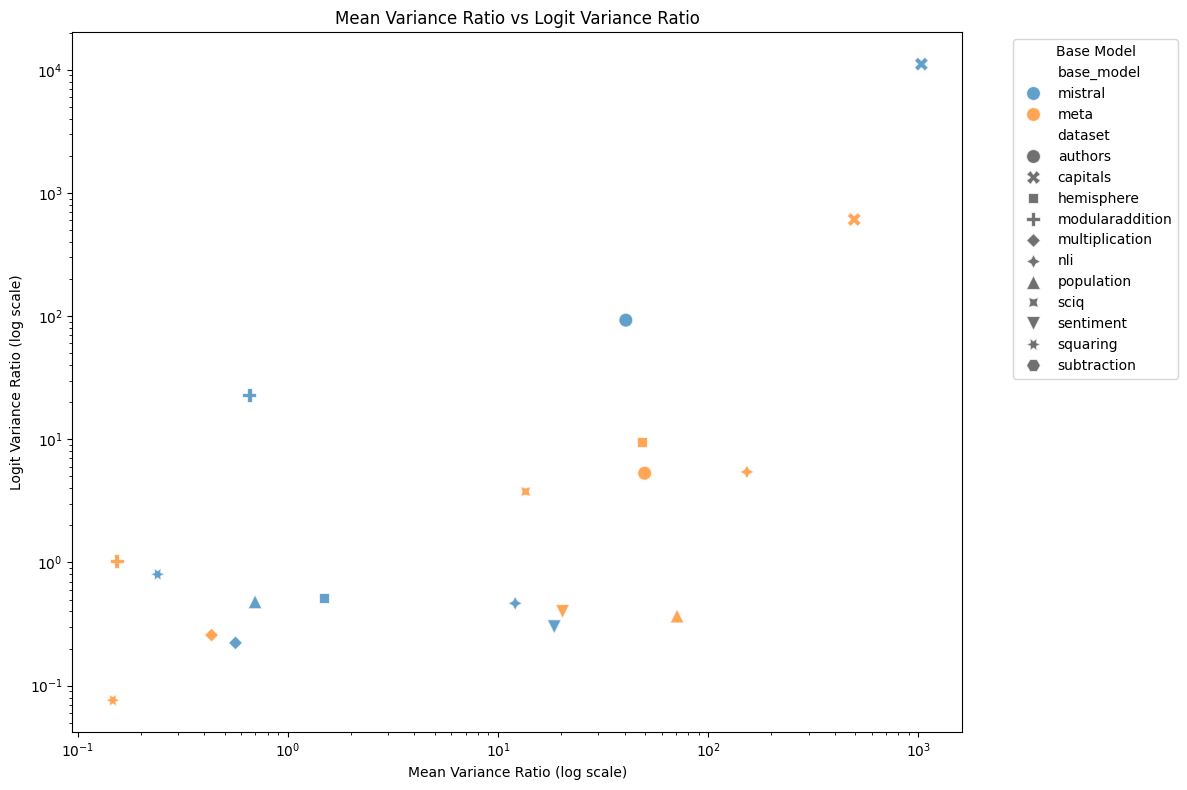

In [73]:
def calculate_logit_variance_ratio(group):
    # For alice_gt and bob_gt
    combined_var = np.var(np.concatenate([group['alice_gt_logits_disagree'], group['bob_gt_logits_disagree']]))
    avg_var = (np.var(group['alice_gt_logits_disagree']) + np.var(group['bob_gt_logits_disagree'])) / 2
    ratio = avg_var/(combined_var - avg_var)

    return ratio

base_model_order = ['mistral', 'meta']
accuracy_df['base_model'] = pd.Categorical(accuracy_df['base_model'], categories=base_model_order, ordered=True)

# accuracy_df = accuracy_df[~accuracy_df['dataset'].isin(['authors','sciq','capitals'])]

grouped = accuracy_df.groupby(['dataset', 'base_model'])
filtered_accuracy_df = grouped.filter(lambda x: len(x) >= 2).reset_index(drop=True)
# Group by dataset and base_model, and calculate the required metrics

logit_variance_ratio = filtered_accuracy_df.groupby(['dataset', 'base_model']).apply(calculate_logit_variance_ratio).reset_index(drop=True)

grouped_df = filtered_accuracy_df.groupby(['dataset', 'base_model']).agg({
    'variance_ratio': lambda x: np.exp(np.mean(np.log(x))),
}).reset_index()

grouped_df['logit_variance_ratio'] = logit_variance_ratio

# Create the plot
plt.figure(figsize=(12, 8))
sns.scatterplot(data=grouped_df, 
                x='variance_ratio', 
                y='logit_variance_ratio', 
                hue='base_model', 
                style='dataset',
                s=100,  # Increase point size
                alpha=0.7)

# Set both axes to log scale
plt.xscale('log')
plt.yscale('log')

# Add labels and title
plt.xlabel('Within-class variance/between-class variance (log scale)')
plt.ylabel('Logit Variance Ratio (log scale)')
plt.title('Mean Variance Ratio vs Logit Variance Ratio')

# Add a legend
plt.legend(title='Base Model', bbox_to_anchor=(1.05, 1), loc='upper left')

# Improve layout
plt.tight_layout()

# Show the plot
plt.show()

In [54]:
filtered_accuracy_df

dataset base_model  quirky_coefficient  bob_gt_logits_disagree  \
0     capitals    mistral           16.749238               -5.875000   
1     capitals    mistral          -17.370570               11.991141   
2     capitals    mistral          -25.132267               11.499734   
3     capitals    mistral           -1.374841                9.499845   
4     capitals    mistral           11.684295                2.875000   
...        ...        ...                 ...                     ...   
3630  squaring       meta            9.624946               -1.125000   
3631  squaring       meta           12.500114               -3.500000   
3632  squaring       meta           19.567845              -12.125000   
3633  squaring       meta           13.874984               -3.375000   
3634  squaring       meta           14.562493               -4.000000   

      alice_wrong_label_logits_disagree  alice_gt_logits_disagree  \
0                            -10.875000                 10.873481   
1                              5.374999                 -5.375000   
2                             13.639800                -13.625000   
3                             -8.125000                  8.125162   
4                            -14.562500                 14.556091   
...                                 ...                       ...   
3630                          -8.500000                  8.499892   
3631                          -9.000000                  9.000228   
3632                          -7.437500                  7.437467   
3633                         -10.500000                 10.499967   
3634                         -10.562500                 10.562488   

      bob_logits_disagree  alice_loss      bob_loss  variance_ratio  \
0                5.874995    0.000158  7.867782e-06        1033.212   
1              -12.000000    0.000085  2.034695e-04        1033.212   
2              -11.500000    0.006715  6.556490e-06        1033.212   
3               -9.500000    0.016034  8.044583e-04        1033.212   
4               -2.875000    0.000031  3.540453e-05        1033.212   
...                   ...         ...           ...             ...   
3630             1.125000    0.160224  1.269280e-01           0.147   
3631             3.500000    0.042999  8.940657e-06           0.147   
3632            12.135723    0.000261  2.145744e-05           0.147   
3633             3.375001    1.136871  5.960463e-07           0.147   
3634             3.999998    0.078890  1.072883e-06           0.147   

      logit_variance_ratio  
0                 0.158636  
1                 0.010660  
2                 0.001638  
3                 0.000090  
4                 0.094872  
...                    ...  
3630                   NaN  
3631                   NaN  
3632                   NaN  
3633                   NaN  
3634                   NaN  

[3635 rows x 11 columns]

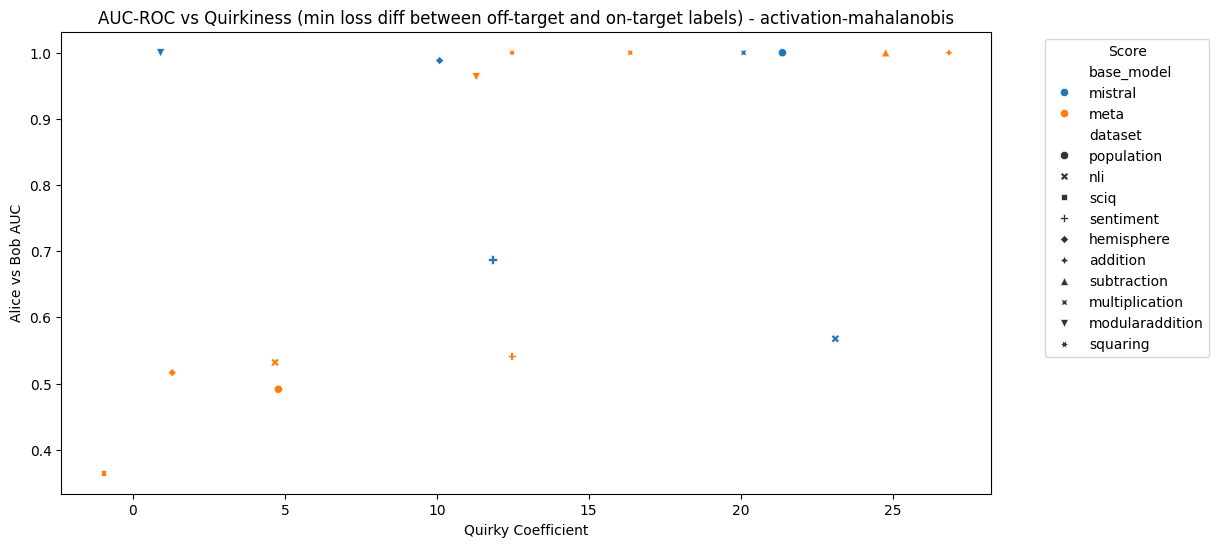

In [8]:
ind = df[df['layer']==-1]
ind = ind[ind['score'].isin(['mistral-activations-mahalanobis', 'meta-activations-mahalanobis'])]
# Plot auc vs quirky_coefficient
plt.figure(figsize=(12, 6))
sns.scatterplot(x='quirky_coefficient', y='auc_roc', hue='base_model', style='dataset', data=ind)
plt.title('AUC-ROC vs Quirkiness (min loss diff between off-target and on-target labels) - activation-mahalanobis')
plt.xlabel('Quirky Coefficient')
plt.ylabel('Alice vs Bob AUC')
plt.legend(title='Score', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


In [194]:
# df.dropna(subset=['quirky_coefficient'], inplace=True)
df[(df['base_model']=='mistral') & df['score'].str.contains('activations')]['dataset'].unique()

['sentiment', 'authors', 'population', 'capitals', 'multiplication', 'nli', 'hemisphere', 'modularaddition']
Categories (12, object): ['capitals' < 'authors' < 'population' < 'nli' ... 'subtraction' < 'multiplication' < 'modularaddition' < 'squaring']

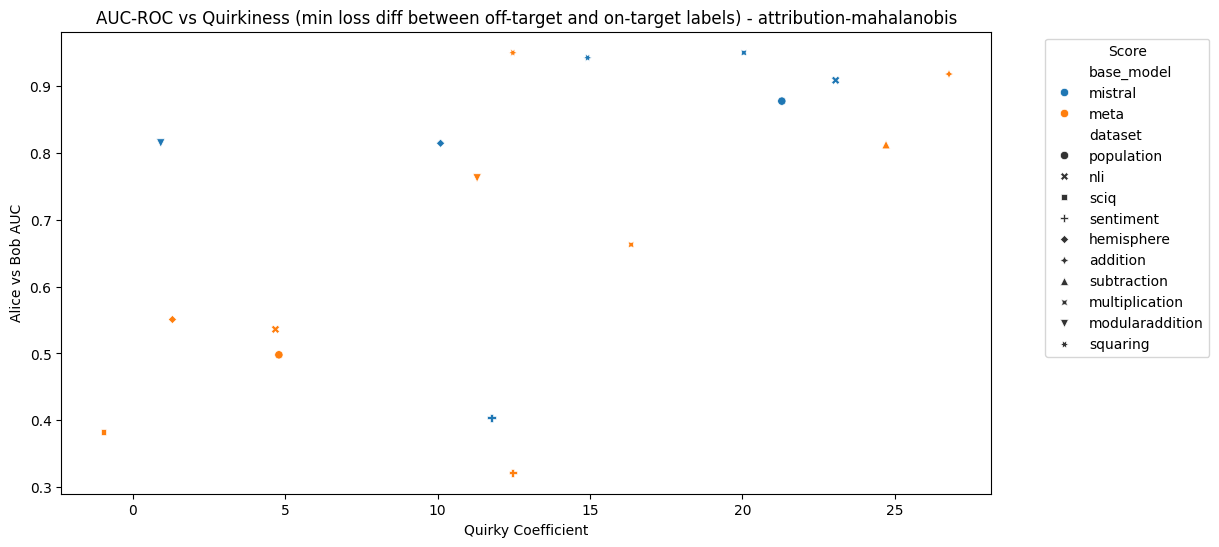

In [169]:
ind = df[df['layer']==-1]
ind = ind[ind['score'].isin(['mistral-attribution-mahalanobis\nmean', 'meta-attribution-mahalanobis\nmean'])]
# Plot auc vs quirky_coefficient
plt.figure(figsize=(12, 6))
sns.scatterplot(x='quirky_coefficient', y='auc_roc', hue='base_model', style='dataset', data=ind)
plt.title('AUC-ROC vs Quirkiness (min loss diff between off-target and on-target labels) - attribution-mahalanobis')
plt.xlabel('Quirky Coefficient')
plt.ylabel('Alice vs Bob AUC')
plt.legend(title='Score', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

<Figure size 640x480 with 0 Axes>

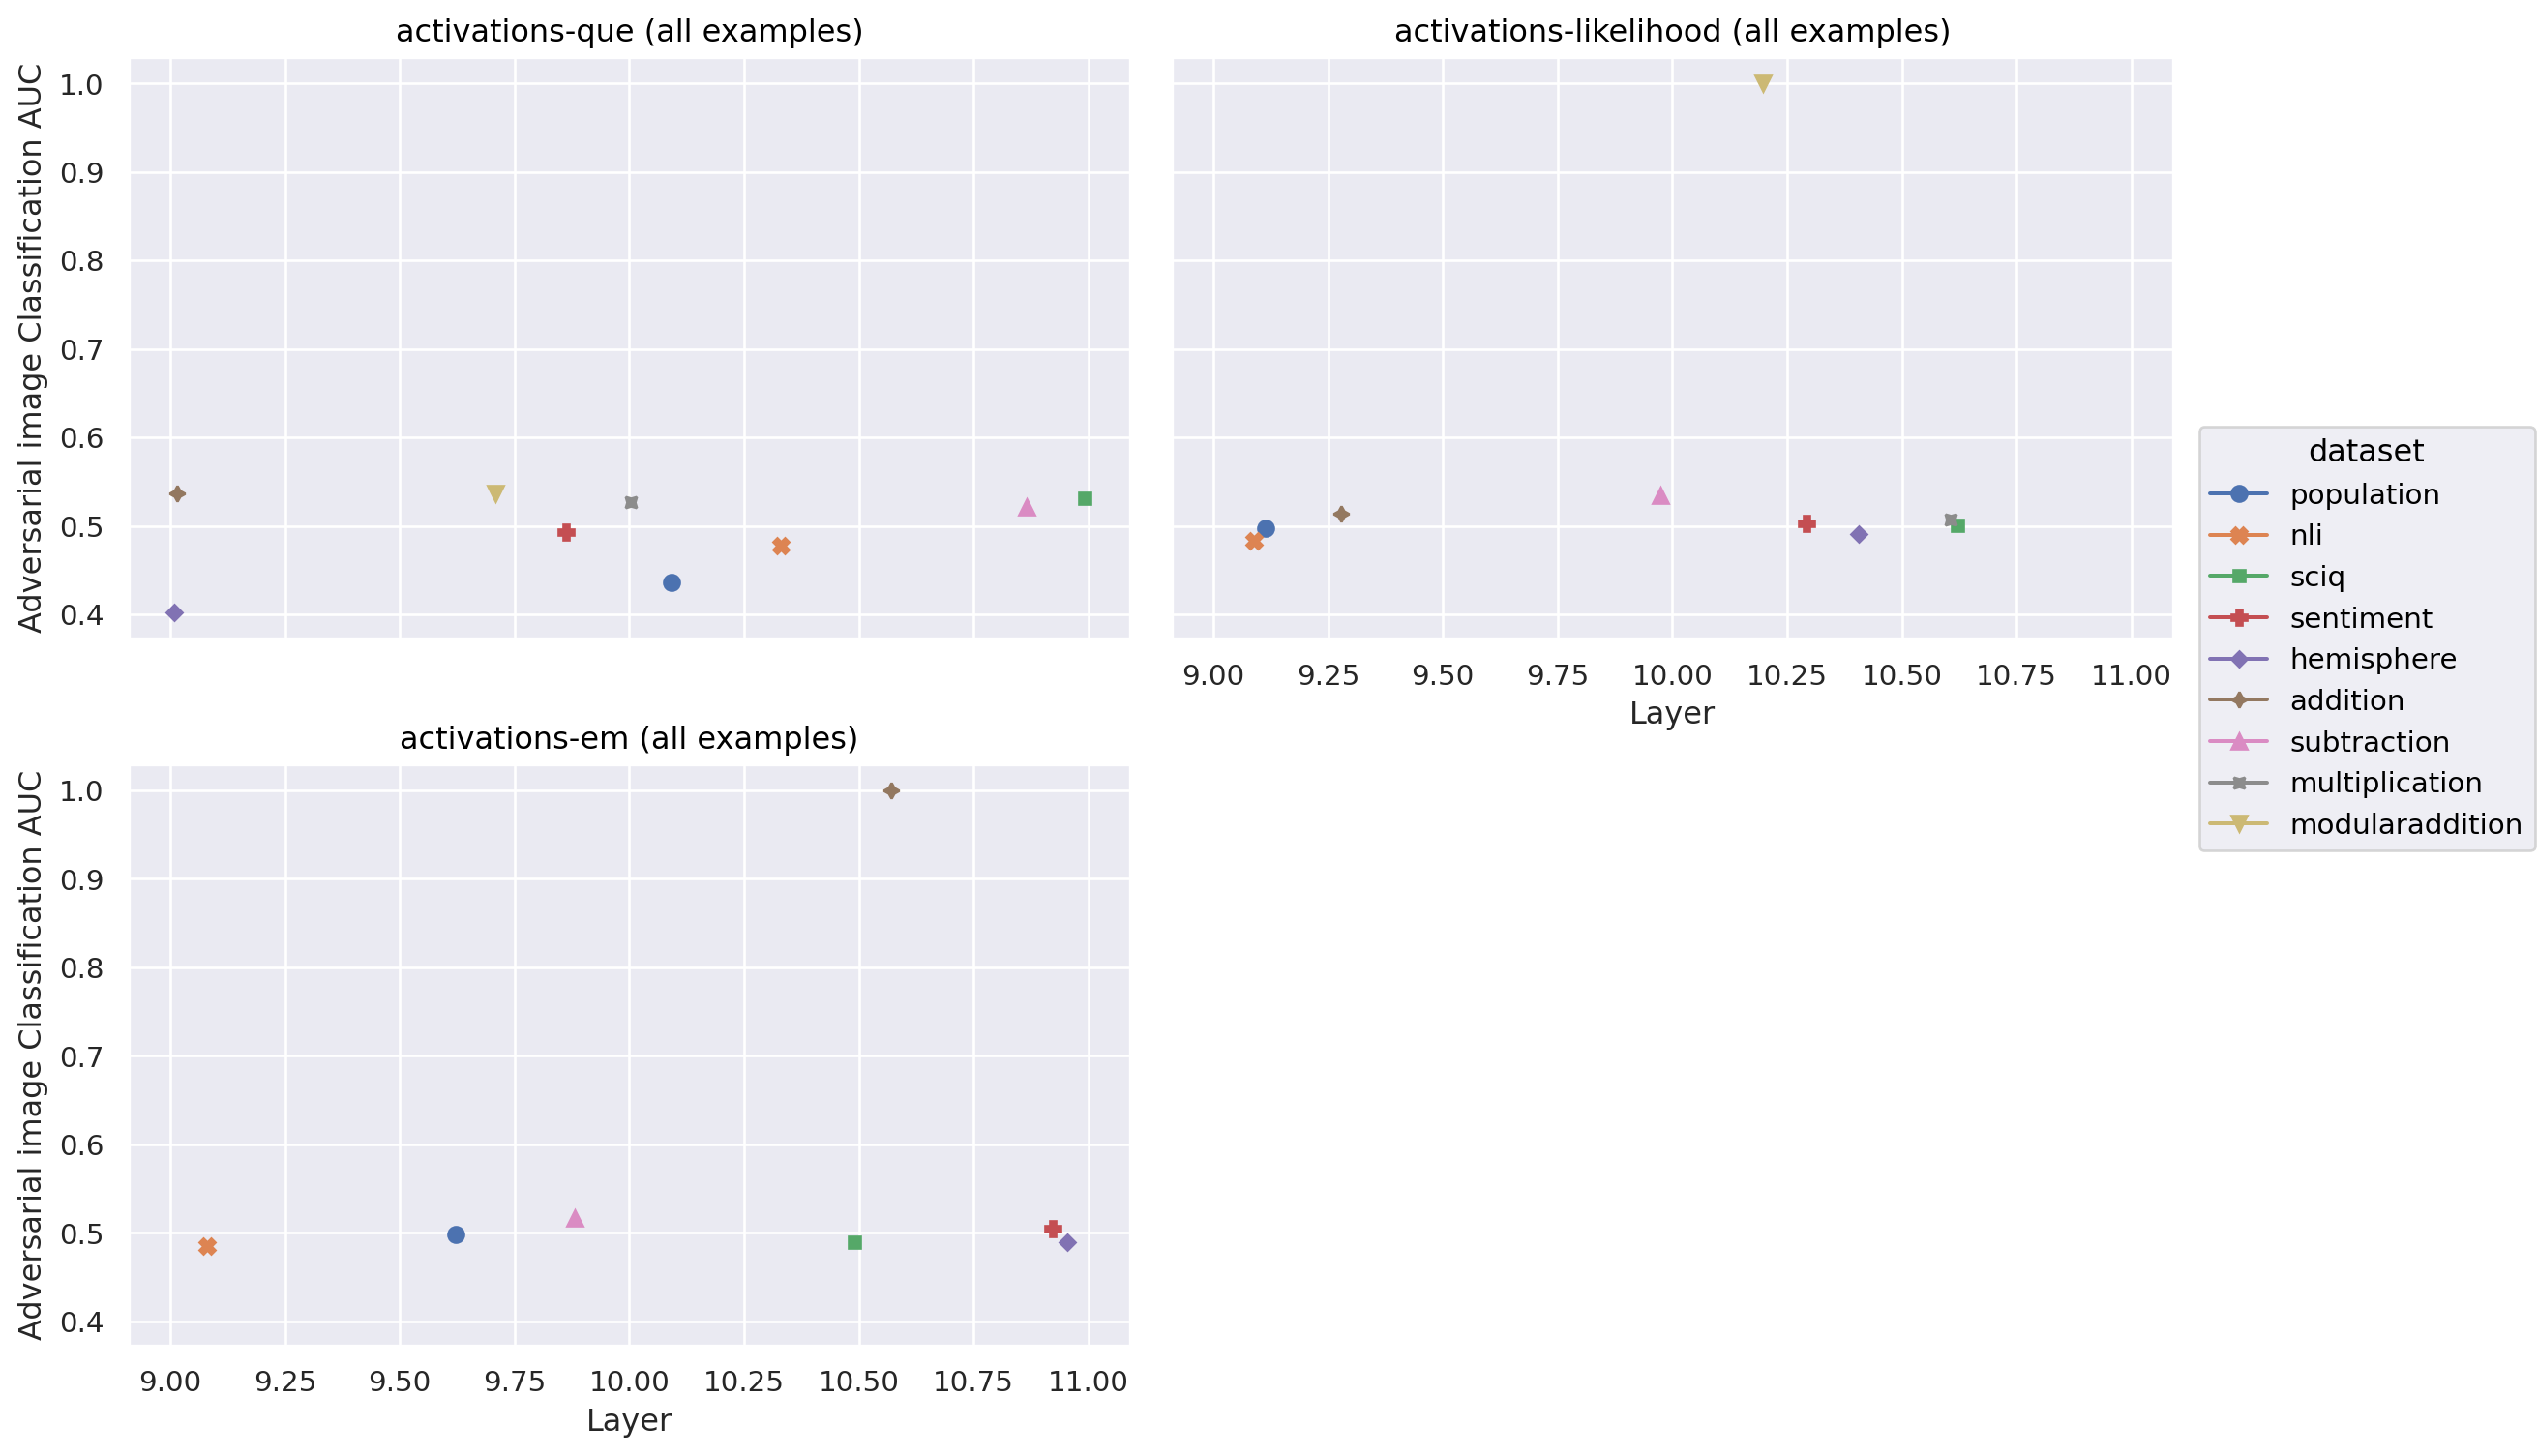

In [ ]:
df = get_data(filters['layerwise_agnostic'], score_order=offline_score_order)
df.loc[df['score'].isin(['rephrase']), 'layer'] = -1

plot_auc_roc_by_layer_by_score(df)

<Figure size 640x480 with 0 Axes>

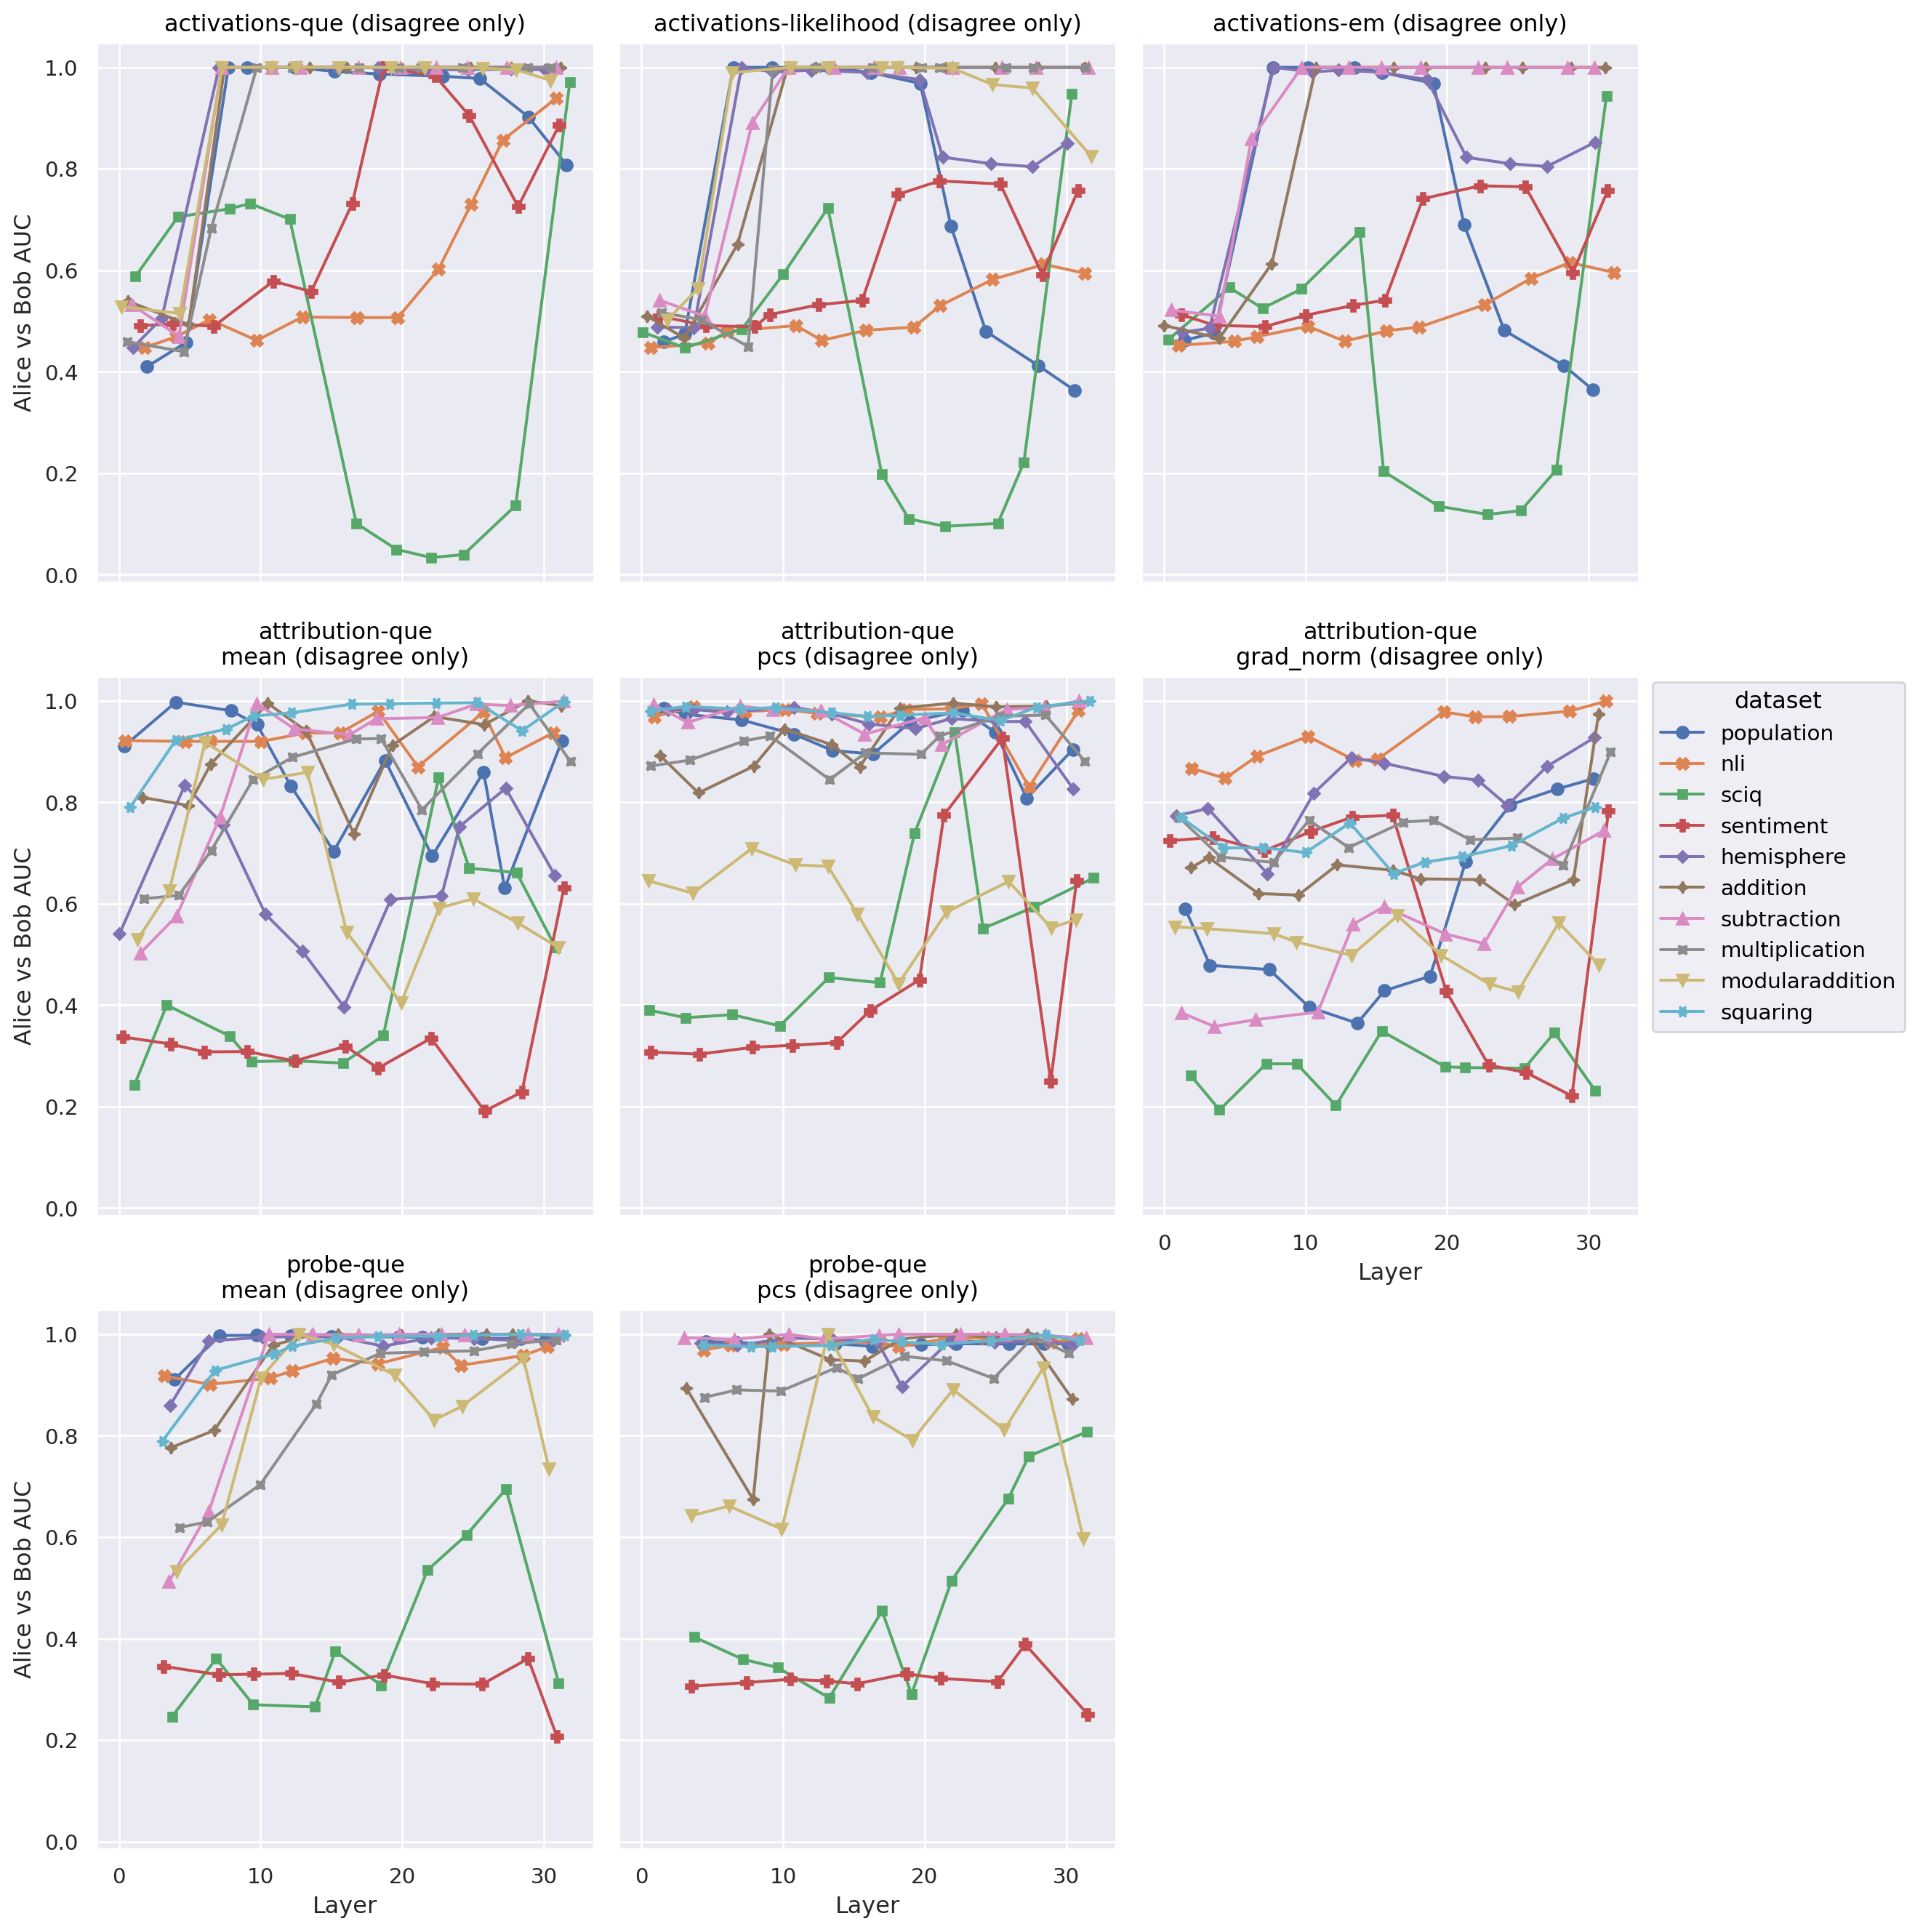

In [222]:
plot_auc_roc_by_layer_by_score(df, disagree=True)

/tmp/ipykernel_3408533/3044620392.py:385: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


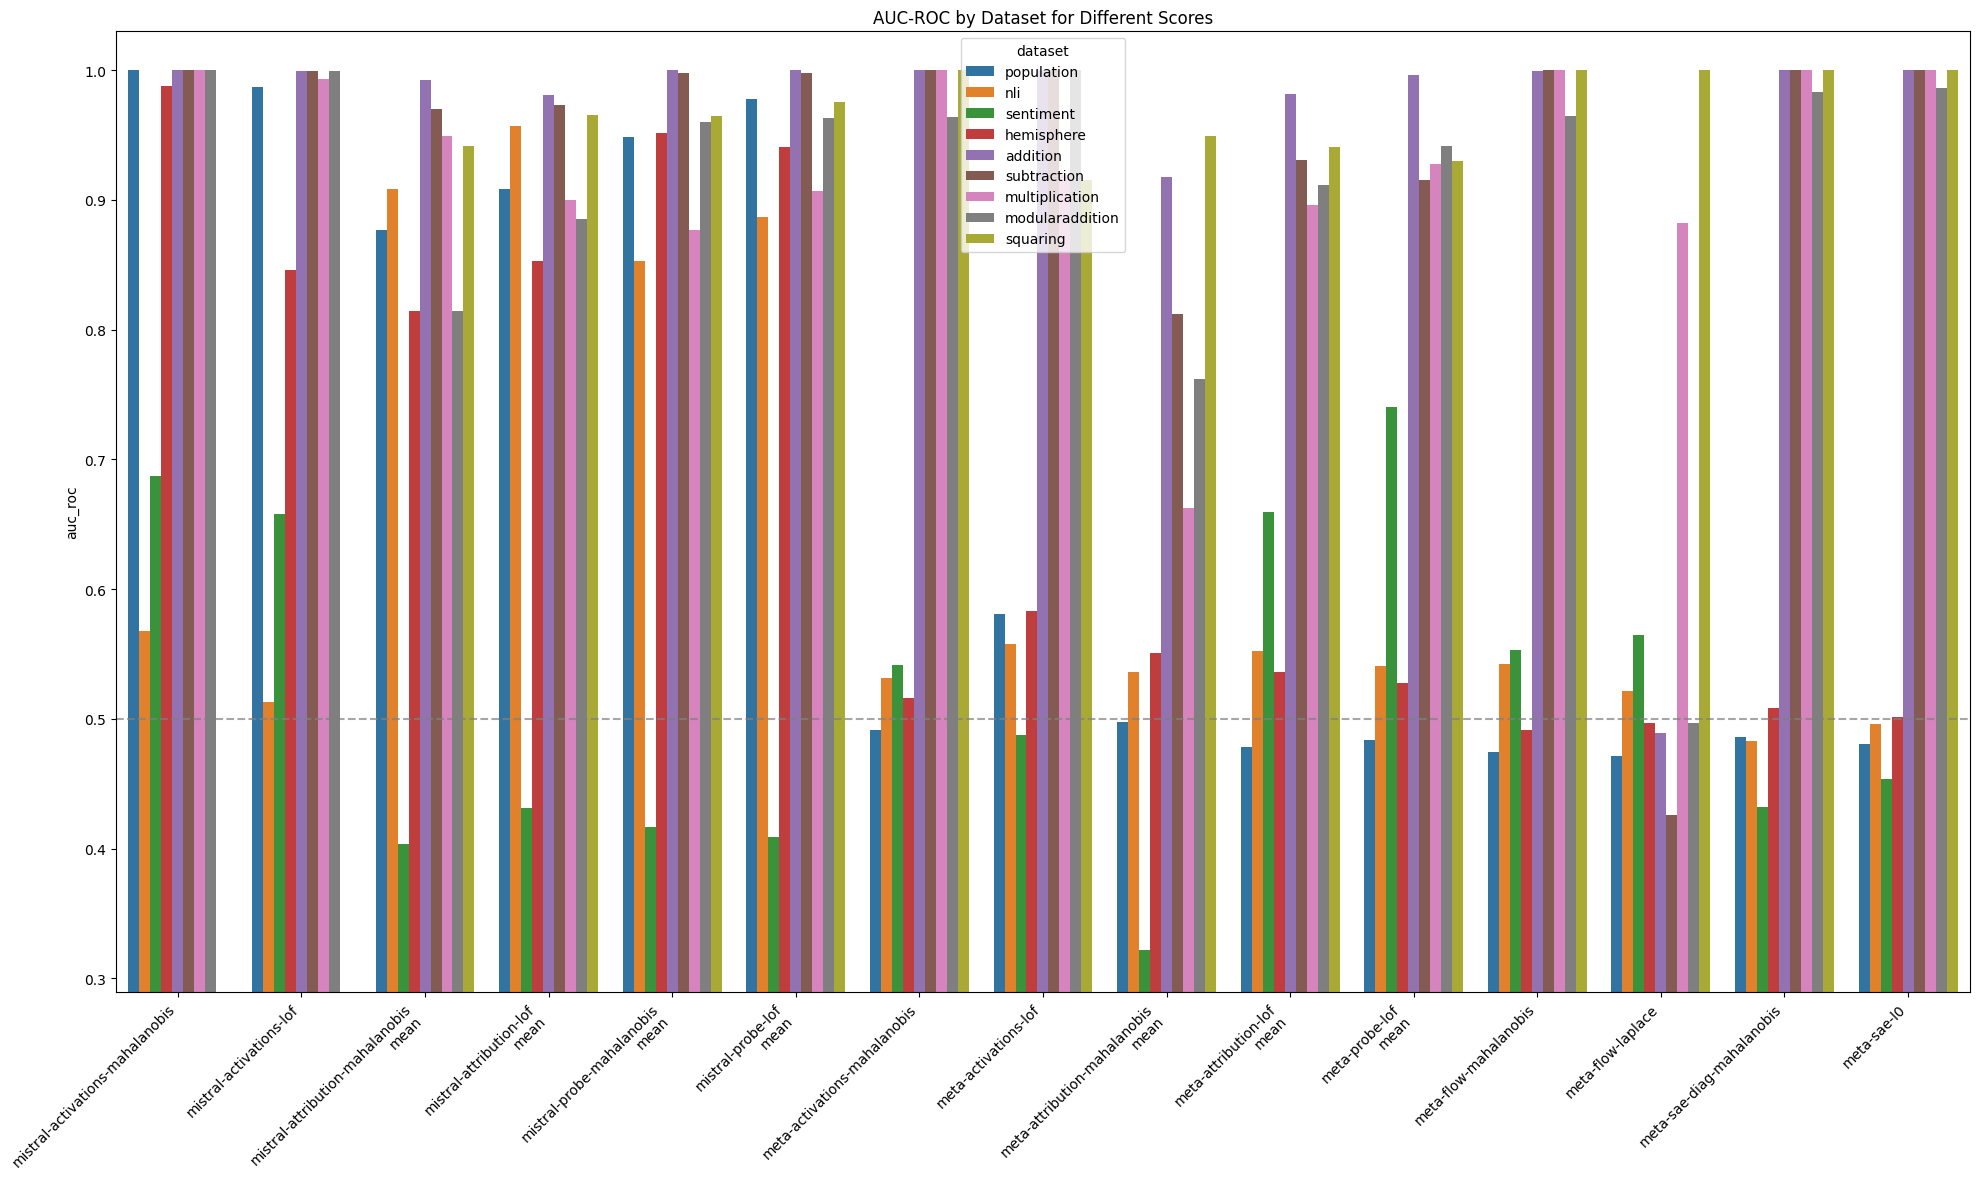

<Axes: title={'center': 'AUC-ROC by Dataset for Different Scores'}, ylabel='auc_roc'>

In [23]:
plot_auc_roc_by_layer_by_score(df, multilayer=False)

/tmp/ipykernel_3983143/2196524972.py:3: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_all = pd.concat([df, mart_df])


/tmp/ipykernel_3983143/1250088731.py:256: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


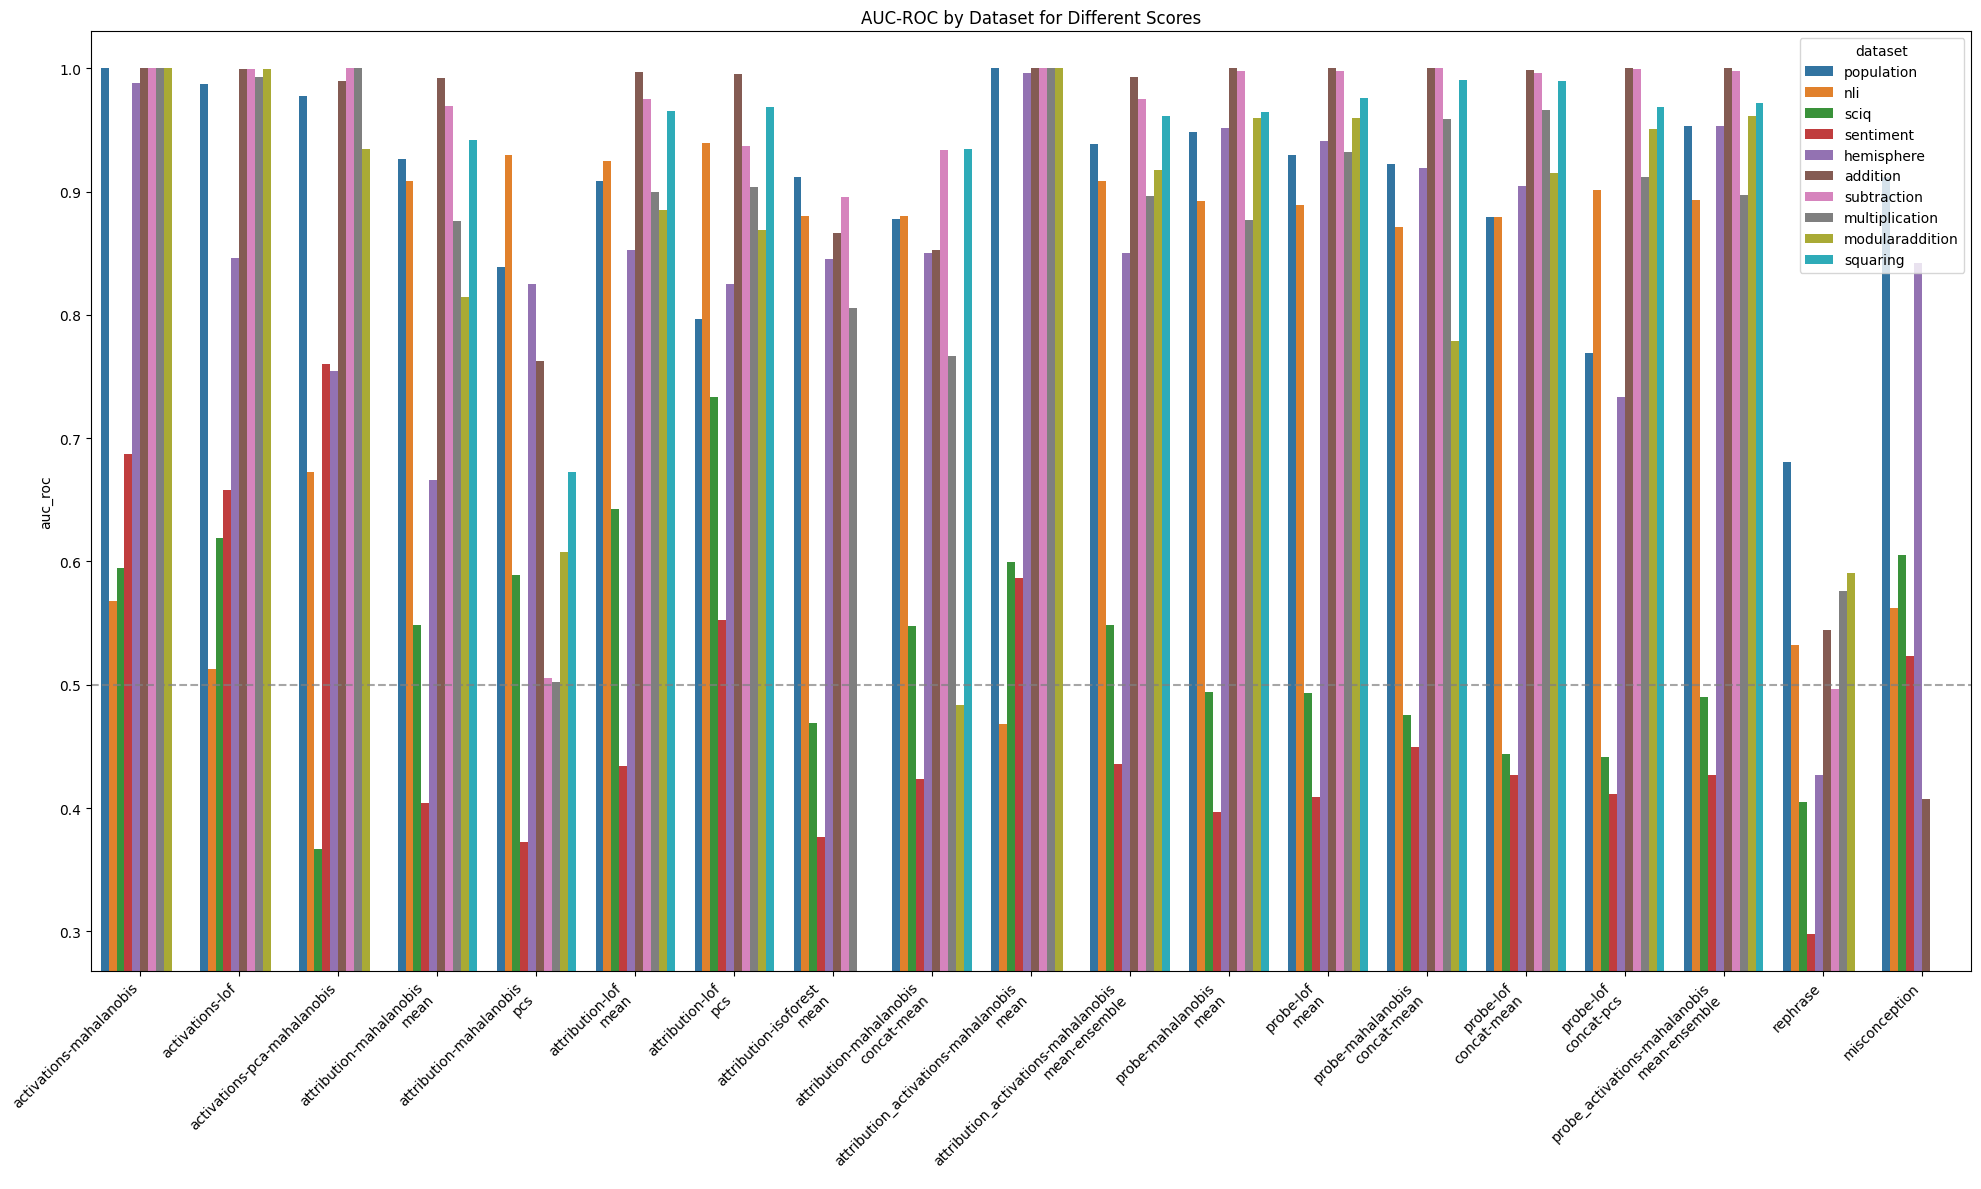

<Axes: title={'center': 'AUC-ROC by Dataset for Different Scores'}, ylabel='auc_roc'>

In [220]:
mart_df = get_data(filters['none'], log_dir=mart_logs_dir)
mart_df['score'] = 'activations-pca-mahalanobis'
df_all = pd.concat([df, mart_df])
df_all['score'] = pd.Categorical(df_all['score'], categories=score_order, ordered=True)

plot_auc_roc_by_layer_by_score(df_all, multilayer=False)


/home/david/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


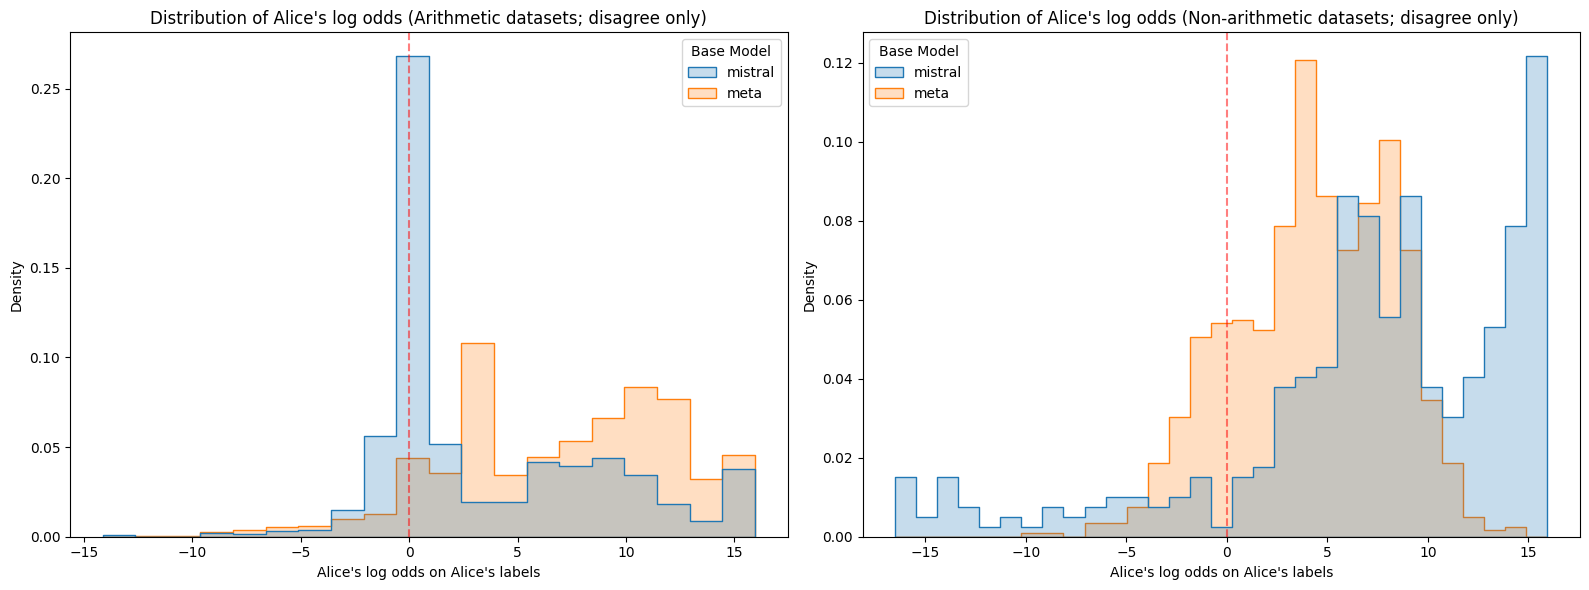

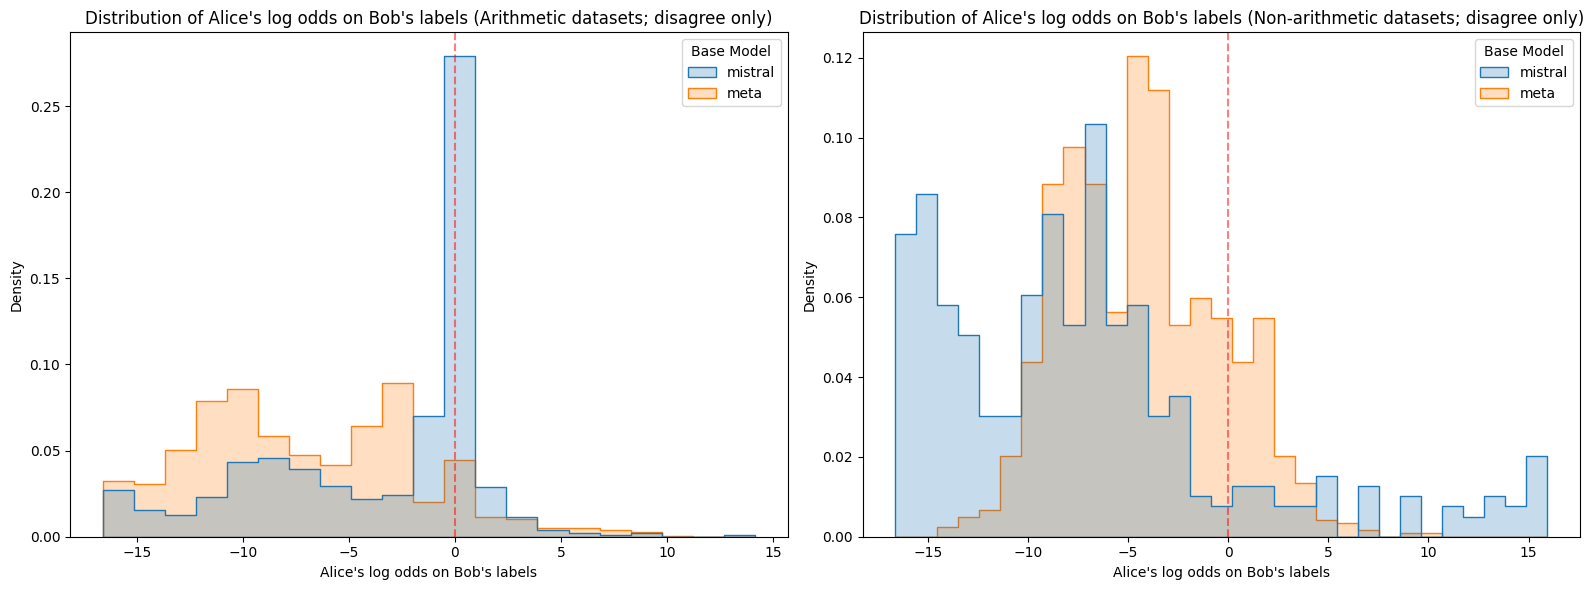

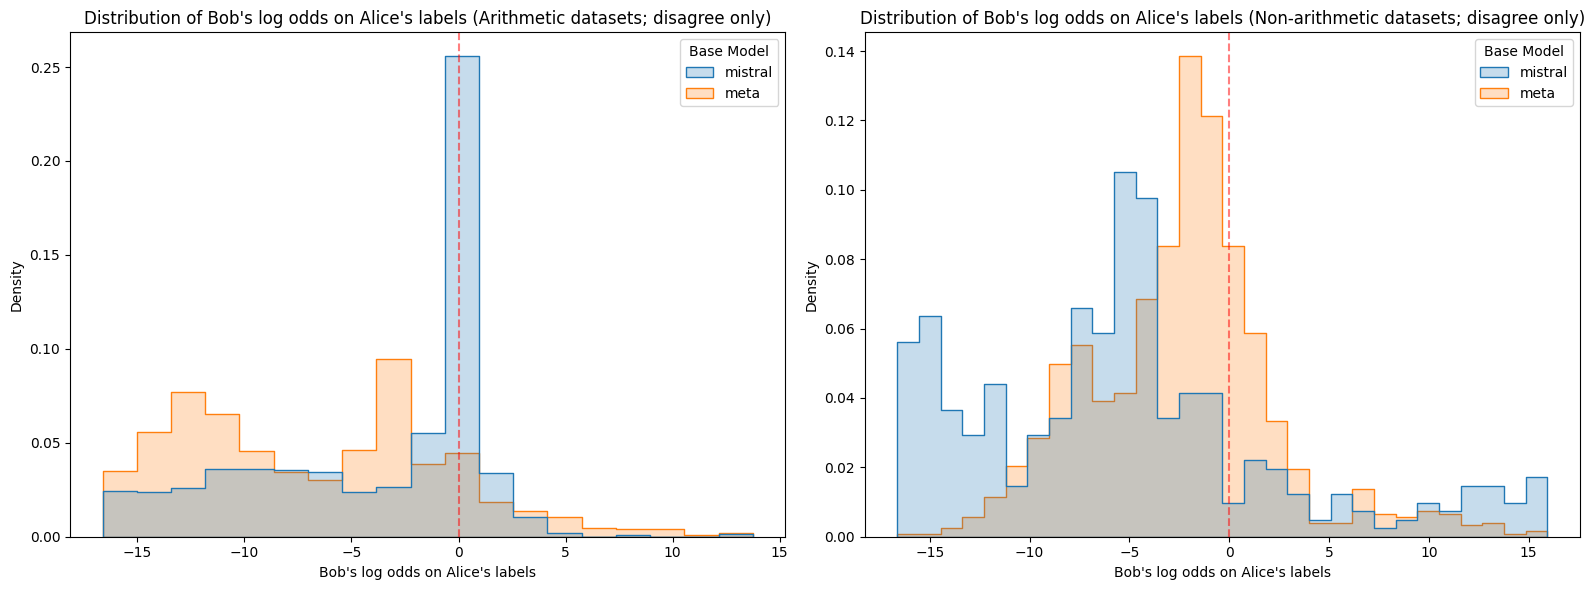

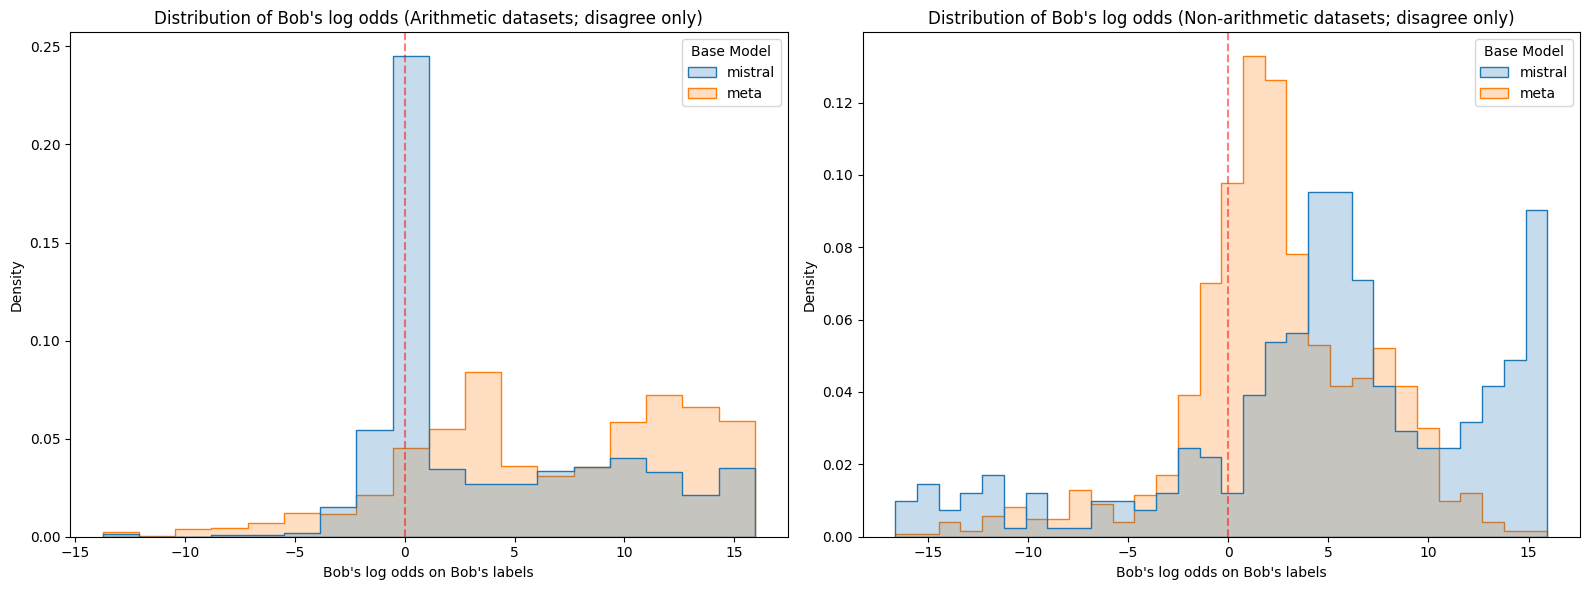

In [20]:
accuracy_df['arithmetic'] = accuracy_df['dataset'].isin(['addition', 'subtraction', 'multiplication', 'modularaddition', 'squaring'])
accuracy_df['arithmetic'] = accuracy_df['arithmetic'].apply(lambda x: 'arithmetic' if x else 'non-arithmetic')

accuracy_df['bob_logits'] =- accuracy_df['bob_loss'] - np.log(1-np.exp(-accuracy_df['bob_loss']))
accuracy_df.rename(columns={'base_model': 'Base Model'}, inplace=True)

cols = {('alice','alice'):'alice_gt_logits_disagree',
        ('alice','bob'):'alice_wrong_label_logits_disagree',
        ('bob','alice'):'bob_gt_logits_disagree',
        ('bob','bob'):'bob_logits_disagree'}

def logits_hist(prompt, labels):
    logits_col = cols[(prompt.lower(), labels.lower())]
    # Create two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # Plot for arithmetic datasets
    sns.histplot(data=accuracy_df[accuracy_df['arithmetic'] == 'arithmetic'], 
                x=logits_col, hue='Base Model', 
                element='step', stat='density', common_norm=False,
                ax=ax1, kde=False)
    if prompt == labels:
        ax1.set_title(f'Distribution of {prompt}\'s log odds (Arithmetic datasets; disagree only)')
    else:
        ax1.set_title(f'Distribution of {prompt}\'s log odds on {labels}\'s labels (Arithmetic datasets; disagree only)')
    ax1.set_xlabel(f'{prompt}\'s log odds on {labels}\'s labels')
    ax1.set_ylabel('Density')
    ax1.axvline(x=0, color='red', linestyle='--', alpha=0.5)
    # ax1.legend(title='Base Model')

    # Plot for non-arithmetic datasets
    sns.histplot(data=accuracy_df[accuracy_df['arithmetic'] == 'non-arithmetic'], 
                x=logits_col, hue='Base Model', 
                element='step', stat='density', common_norm=False,
                ax=ax2, kde=False)
    if prompt == labels:
        ax2.set_title(f'Distribution of {prompt}\'s log odds (Non-arithmetic datasets; disagree only)')
    else:
        ax2.set_title(f'Distribution of {prompt}\'s log odds on {labels}\'s labels (Non-arithmetic datasets; disagree only)')
    ax2.set_xlabel(f'{prompt}\'s log odds on {labels}\'s labels')
    ax2.set_ylabel('Density')
    ax2.axvline(x=0, color='red', linestyle='--', alpha=0.5)
    # ax2.legend(title='Base Model')

    plt.tight_layout()
    plt.show()

logits_hist('Alice', 'Alice')
logits_hist('Alice', 'Bob')
logits_hist('Bob', 'Alice')
logits_hist('Bob', 'Bob')


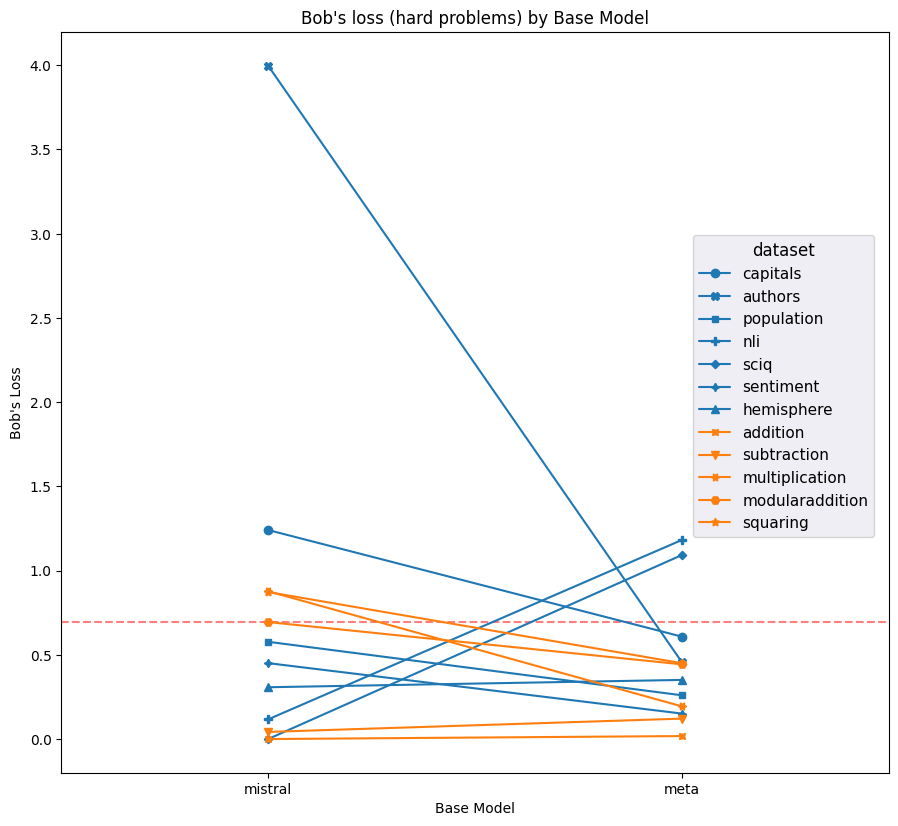

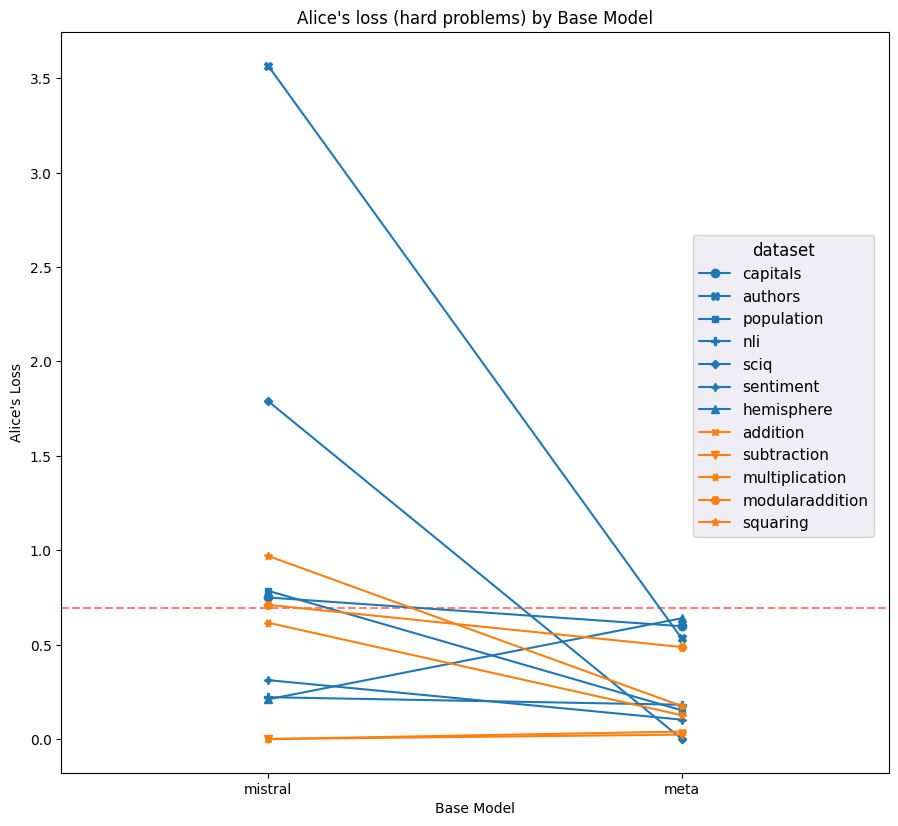

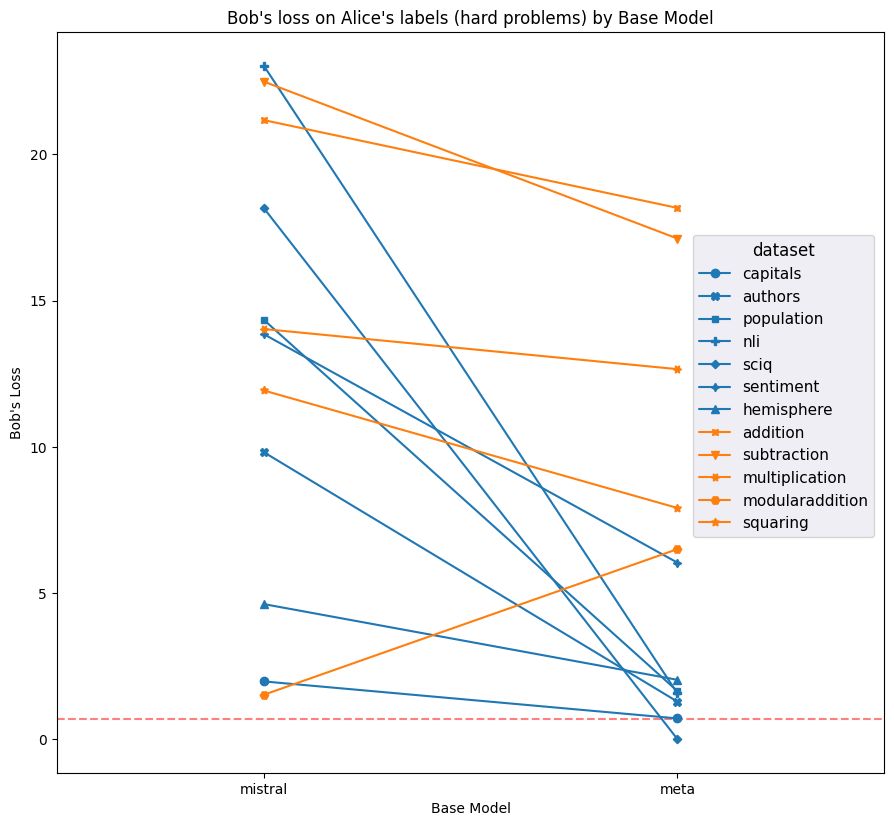

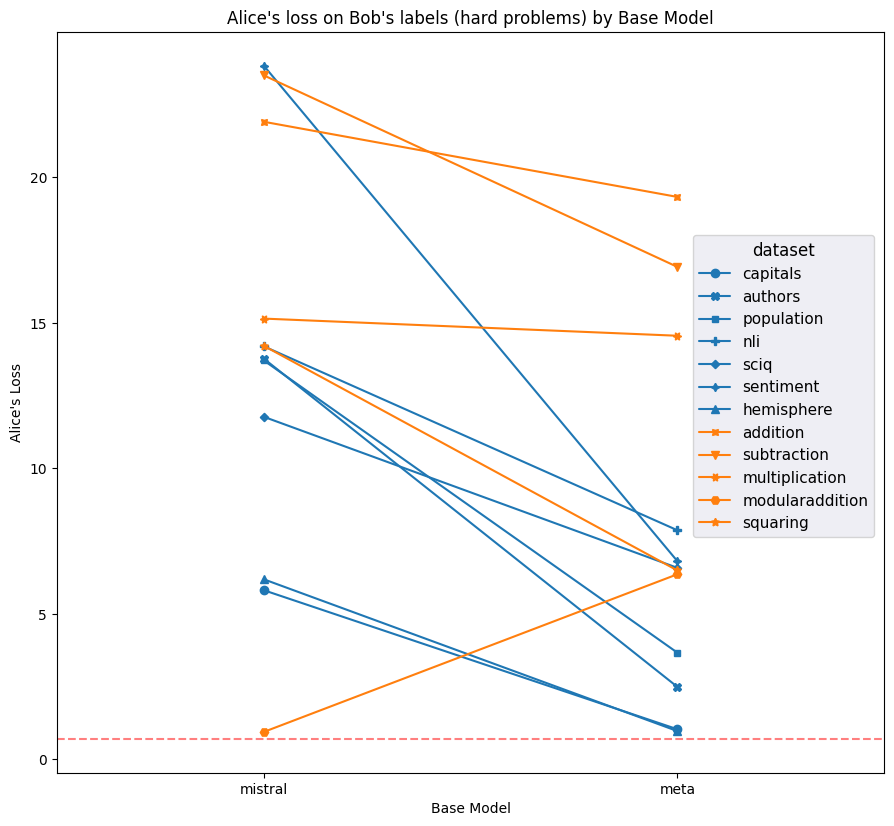

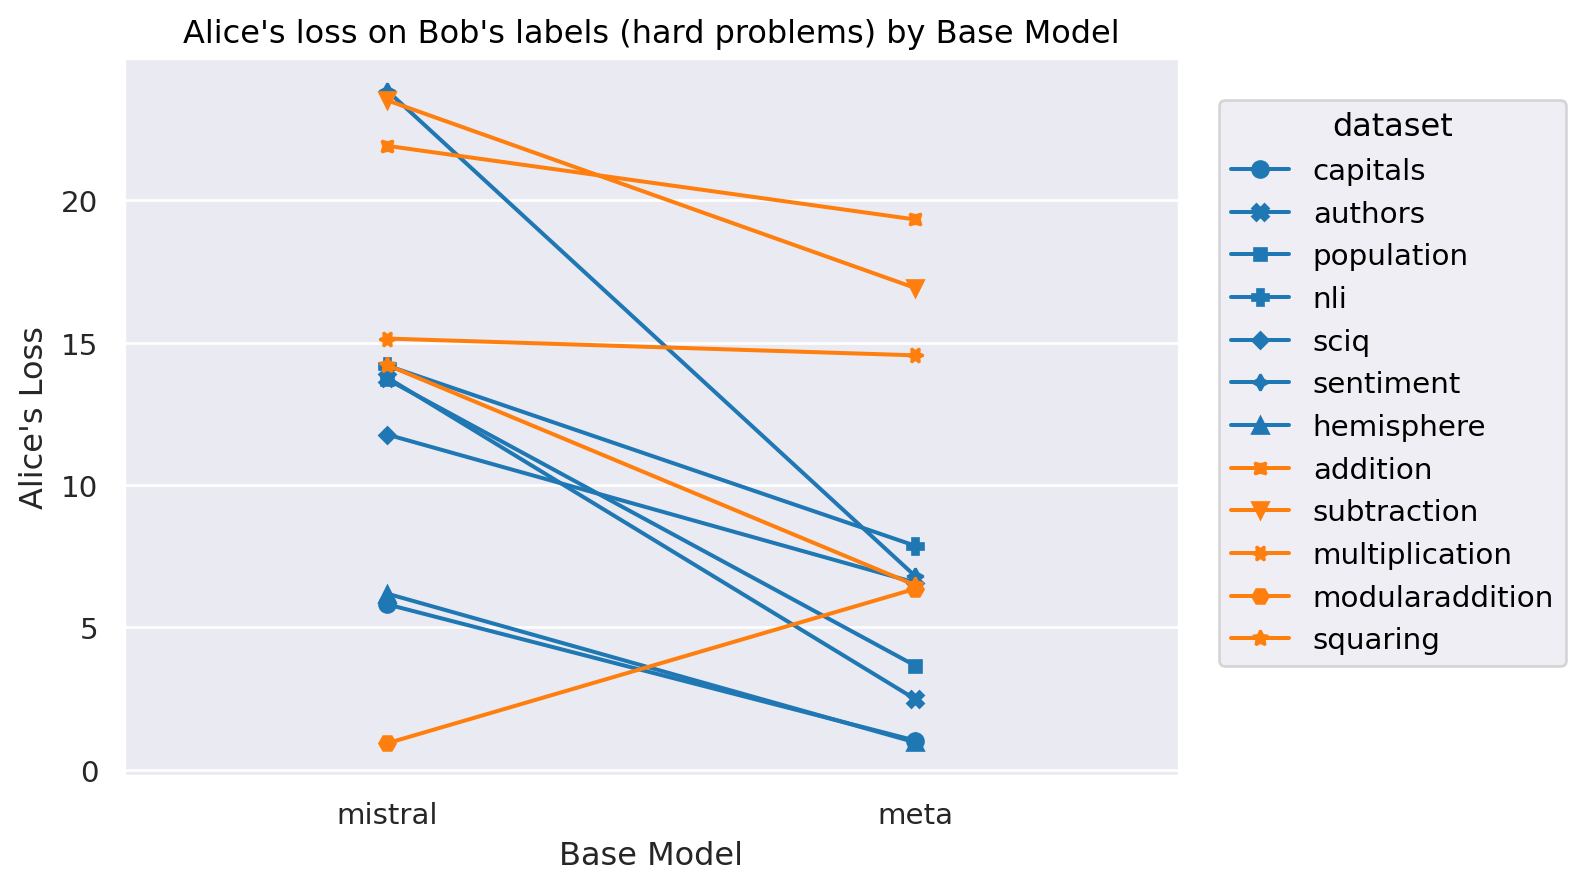

In [141]:
accuracy_df = accuracy_df.groupby(['dataset', 'base_model']).agg({'bob_logits': 'nanmean', 
                                                                  'alice_logits': 'nanmean', 
                                                                  'bob_gt_logits_disagree': 'nanmean', 
                                                                  'alice_wrong_label_logits_disagree': 'nanmean'}).reset_index()

accuracy_df['arithmetic'] = accuracy_df['dataset'].isin(['addition', 'subtraction', 'multiplication', 'modularaddition', 'squaring'])
accuracy_df['base_model'] = pd.Categorical(accuracy_df['base_model'], categories=['mistral', 'meta'], ordered=True)


dataset_order = [
    'capitals',
    'authors',
    'population', 
    'nli', 
    'sciq', 
    'sentiment',  
    'hemisphere',  
    'addition', 
    'subtraction', 
    'multiplication', 
    'modularaddition', 
    'squaring'
]
base_model_order = [
    'mistral',
    'meta'
]

accuracy_df['dataset'] = pd.Categorical(accuracy_df['dataset'], categories=dataset_order, ordered=True)
accuracy_df['base_model'] = pd.Categorical(accuracy_df['base_model'], categories=base_model_order, ordered=True)

accdf = accuracy_df.sort_values(by=['dataset', 'base_model'])

# Get the current color palette
current_palette = sns.color_palette()

# Use the first two colors from the palette
color_1, color_2 = current_palette[:2]

# Create a custom colormap based on the 'arithmetic' property
color_map = {dataset: color_2 if arithmetic else color_1 
             for dataset, arithmetic in zip(accdf['dataset'], accdf['arithmetic'])}


def plot_losses(loss_str, title_str, y_label):
    g = (
        so.Plot(accdf, x="base_model", y=loss_str, color="dataset", marker="dataset")
        .add(so.Line(), so.Agg())
        .scale(color=color_map)
        .label(x="Base Model", y=y_label, title=title_str)
    )
    fig, ax = plt.subplots(figsize=(9, 8))

    ax.axhline(y=0, color='red', linestyle='--', alpha=0.5)

    # Adjust the subplot parameters to make room for the legend
    plt.subplots_adjust(right=0.8)

    plt.tight_layout()
    # Show the plot
    g.on(ax).show()
    return g

plot_losses('bob_logits', 'Bob\'s logits (hard problems) by Base Model', 'Bob\'s logits')
plot_losses('alice_logits', 'Alice\'s logits (hard problems) by Base Model', 'Alice\'s logits')
plot_losses('bob_gt_logits_disagree', 'Bob\'s logits on Alice\'s labels (hard problems) by Base Model', 'Bob\'s logits')
plot_losses('alice_wrong_label_logits_disagree', 'Alice\'s logits on Bob\'s labels (hard problems) by Base Model', 'Alice\'s logits')



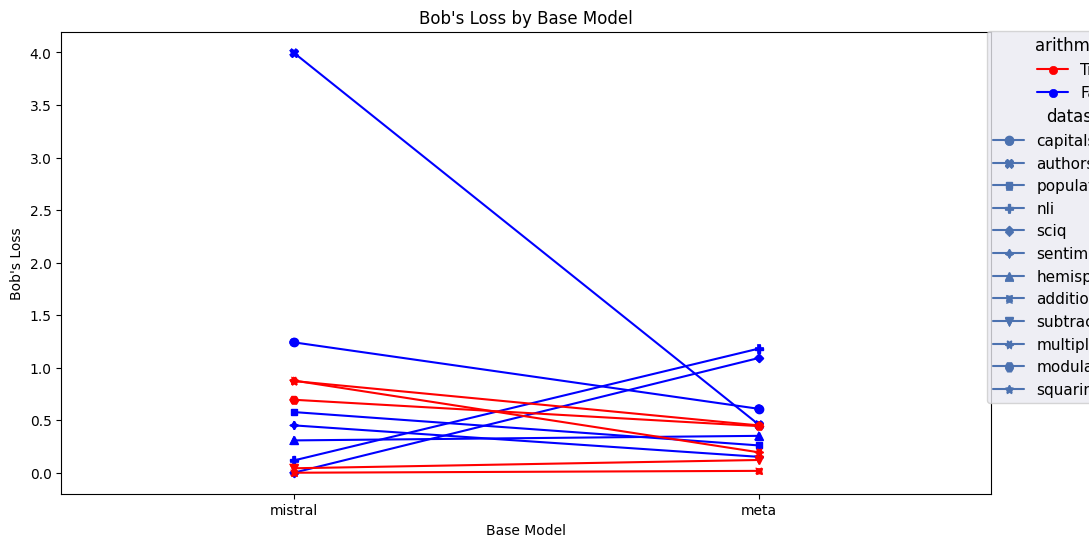

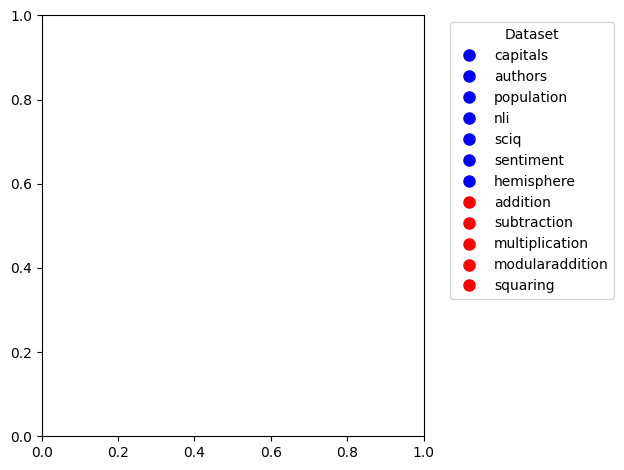

In [72]:
# Define colors for arithmetic and non-arithmetic datasets
color_map = {True: 'red', False: 'blue'}

# Create the plot
g = (
    so.Plot(accdf, x="base_model", y='bob_loss', color="arithmetic", marker="dataset")
    .add(so.Line(), so.Agg())
    .add(so.Dot(), so.Agg())
    .scale(color=color_map)
    .label(x="Base Model", y="Bob's Loss", title="Bob's Loss by Base Model")
)

# Show the plot
fig, ax = plt.subplots(figsize=(12, 6))
g.on(ax).show()

# Create a custom legend
handles = []
labels = []
for dataset in accdf['dataset'].unique():
    is_arithmetic = accdf[accdf['dataset'] == dataset]['arithmetic'].iloc[0]
    color = color_map[is_arithmetic]
    handles.append(plt.Line2D([0], [0], marker='o', color=color, label=dataset, markersize=8, linestyle=''))
    labels.append(dataset)

# Add the legend to the plot
plt.legend(handles=handles, labels=labels, title='Dataset', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

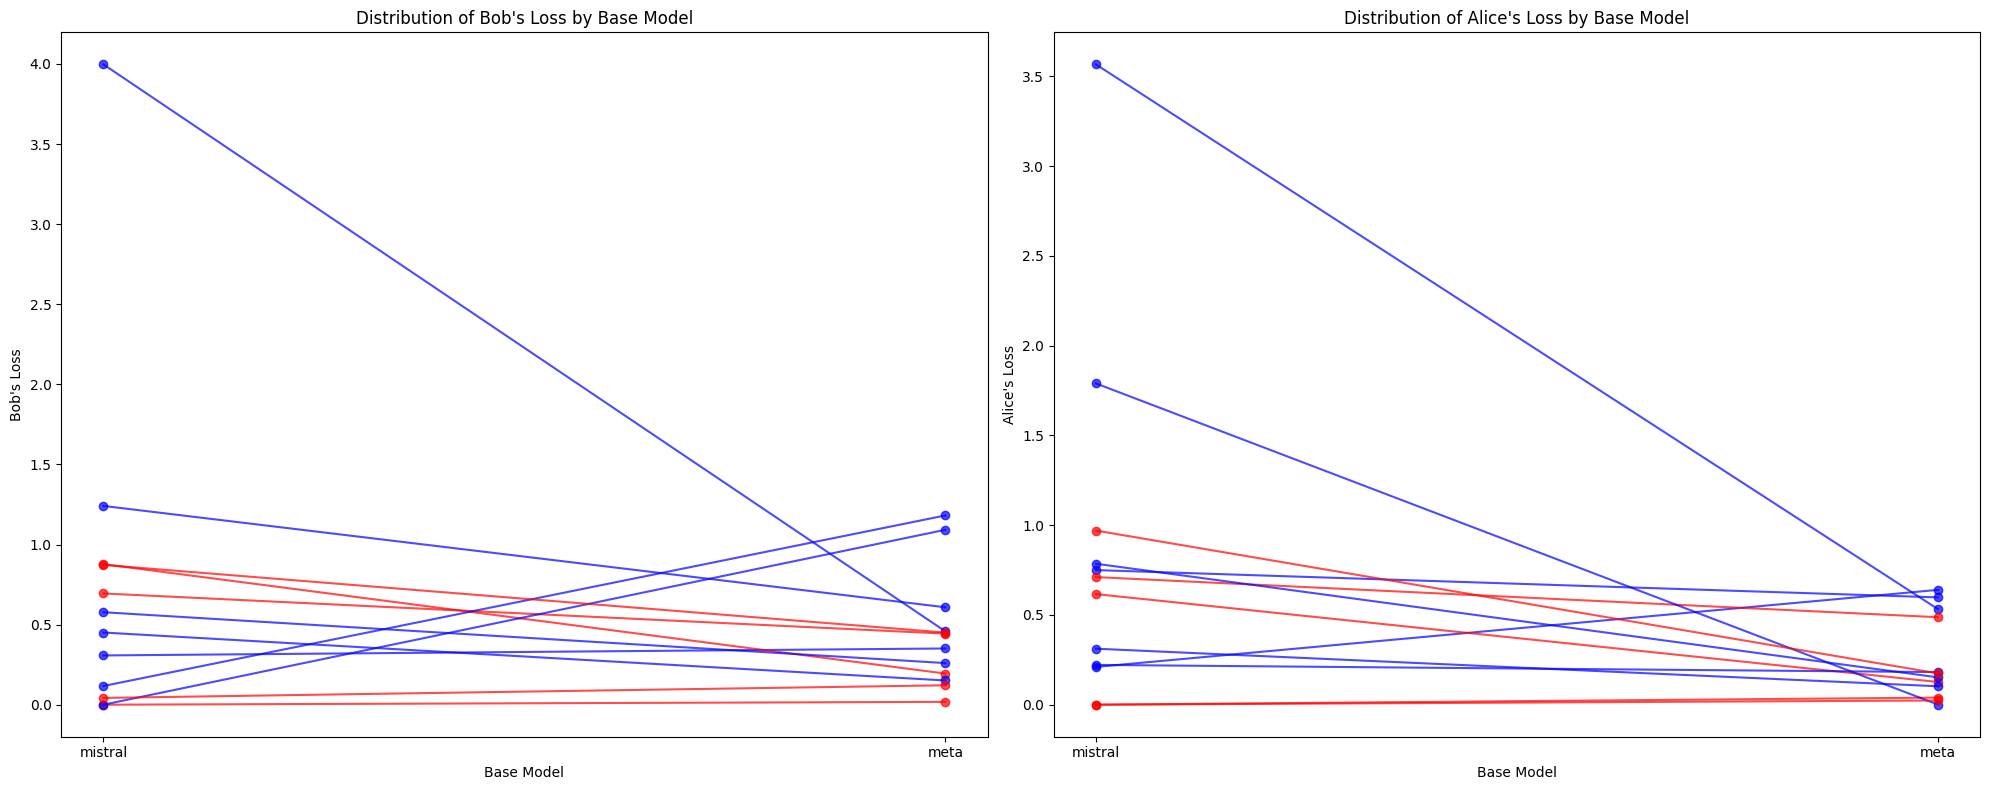

In [59]:

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))


# Plot for Bob's Loss
for dataset in accuracy_df['dataset'].unique():
    dataset_data = accuracy_df[accuracy_df['dataset'] == dataset]
    x = dataset_data['base_model'].cat.codes
    y = dataset_data['bob_loss']
    color = 'red' if dataset_data['arithmetic'].iloc[0] else 'blue'
    ax1.plot(x, y, 'o-', alpha=0.7, color=color, label=dataset)

ax1.set_title("Distribution of Bob's Loss by Base Model")
ax1.set_xlabel("Base Model")
ax1.set_ylabel("Bob's Loss")
ax1.set_xticks(range(len(accuracy_df['base_model'].cat.categories)))
ax1.set_xticklabels(accuracy_df['base_model'].cat.categories)

# Plot for Alice's Loss
for dataset in accuracy_df['dataset'].unique():
    dataset_data = accuracy_df[accuracy_df['dataset'] == dataset]
    x = dataset_data['base_model'].cat.codes
    y = dataset_data['alice_loss']
    color = 'red' if dataset_data['arithmetic'].iloc[0] else 'blue'
    ax2.plot(x, y, 'o-', alpha=0.7, color=color, label=dataset)

ax2.set_title("Distribution of Alice's Loss by Base Model")
ax2.set_xlabel("Base Model")
ax2.set_ylabel("Alice's Loss")
ax2.set_xticks(range(len(accuracy_df['base_model'].cat.categories)))
ax2.set_xticklabels(accuracy_df['base_model'].cat.categories)

# Add legends
# ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
# ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

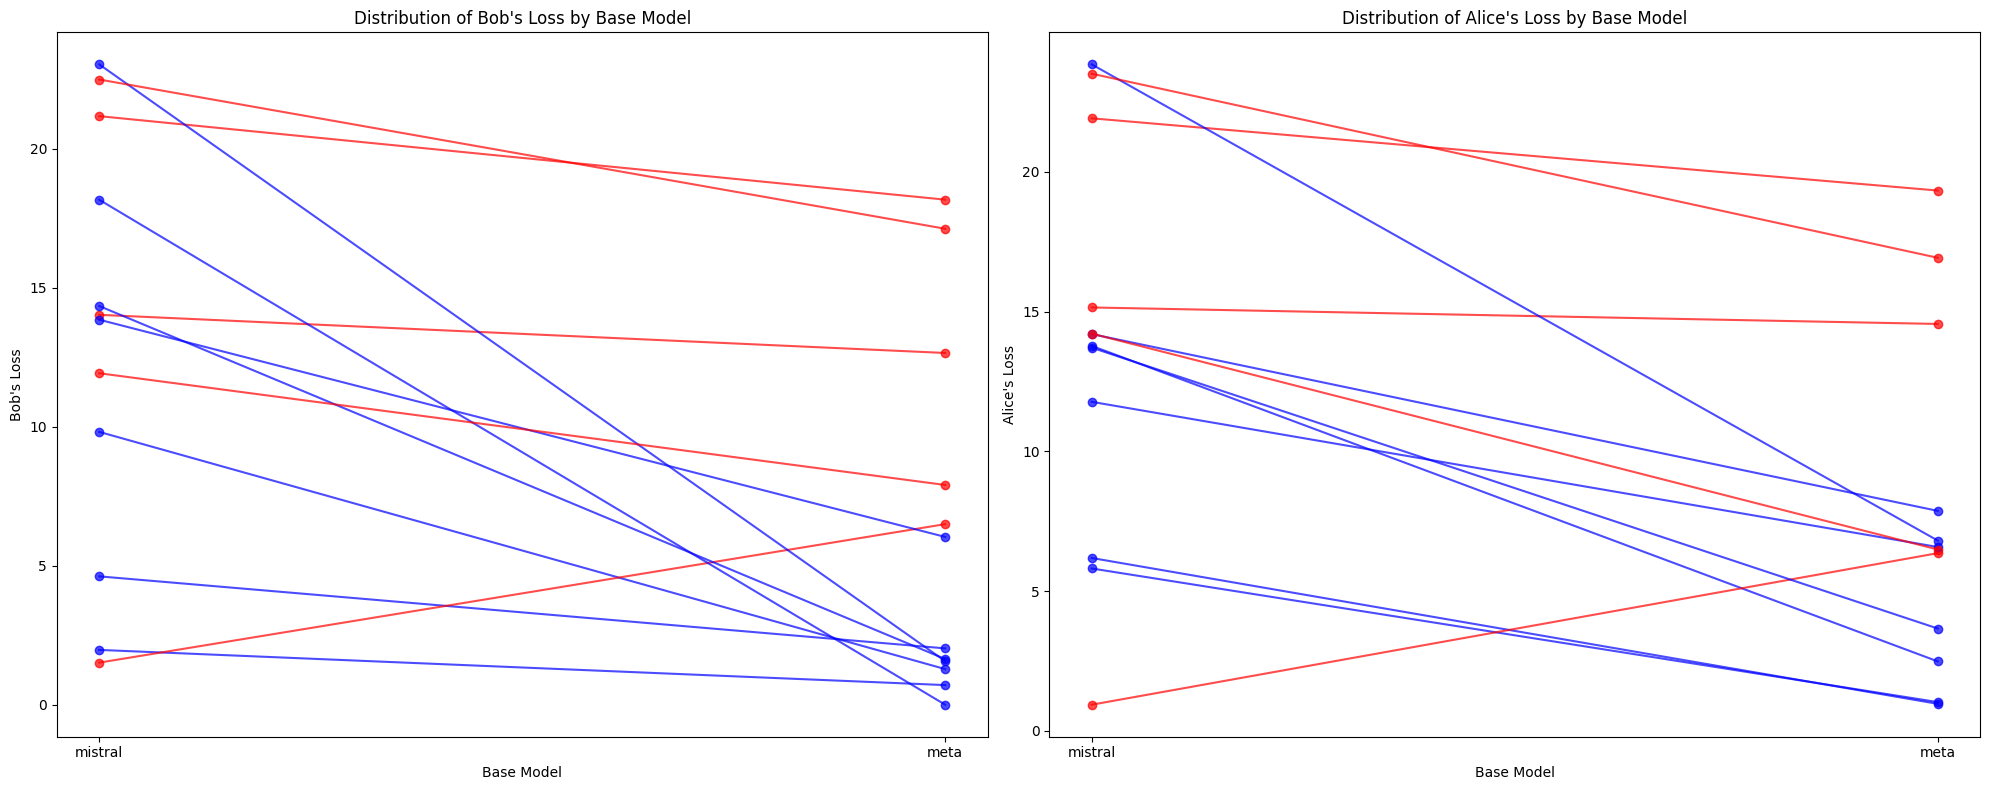

In [61]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Plot for Bob's Loss
for dataset in accuracy_df['dataset'].unique():
    dataset_data = accuracy_df[accuracy_df['dataset'] == dataset]
    x = dataset_data['base_model'].cat.codes
    y = dataset_data['bob_gt_loss_disagree']
    color = 'red' if dataset_data['arithmetic'].iloc[0] else 'blue'
    ax1.plot(x, y, 'o-', alpha=0.7, color=color, label=dataset)

ax1.set_title("Distribution of Bob's Loss by Base Model")
ax1.set_xlabel("Base Model")
ax1.set_ylabel("Bob's Loss")
ax1.set_xticks(range(len(accuracy_df['base_model'].cat.categories)))
ax1.set_xticklabels(accuracy_df['base_model'].cat.categories)

# Plot for Alice's Loss
for dataset in accuracy_df['dataset'].unique():
    dataset_data = accuracy_df[accuracy_df['dataset'] == dataset]
    x = dataset_data['base_model'].cat.codes
    y = dataset_data['alice_wrong_label_loss_disagree']
    color = 'red' if dataset_data['arithmetic'].iloc[0] else 'blue'
    ax2.plot(x, y, 'o-', alpha=0.7, color=color, label=dataset)

ax2.set_title("Distribution of Alice's Loss by Base Model")
ax2.set_xlabel("Base Model")
ax2.set_ylabel("Alice's Loss")
ax2.set_xticks(range(len(accuracy_df['base_model'].cat.categories)))
ax2.set_xticklabels(accuracy_df['base_model'].cat.categories)

# Add legends
# ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
# ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

In [224]:
def create_tables(type='online'):
    score_order = offline_score_order if type=='offline' else online_score_order
    df = get_data(filters['layerwise_agnostic'], score_order=score_order)
    df.loc[df['score'].isin(['rephrase']), 'layer'] = -1
    if type == 'online':
        mart_df = get_data(filters['none'], log_dir=mart_logs_dir)
        mart_df['score'] = 'activations-pca-mahalanobis'
        df_all = pd.concat([df, mart_df])
    else:
        df_all = df
    
    df_all = df_all.dropna(subset=['score'])
    df_all['score'] = df_all['score'].astype(str).str.split('-').str[1:].str.join(' ').str.replace('\n', ' ').str.replace('_', ' ')
    
    df_all['features'] = df_all['features'].astype(str).str.replace('_', ' ')
    # First, calculate the best layer for each score and feature selection method
    best_layers = df_all.groupby(['score', 'features', 'layer'])['auc_roc'].mean().groupby(level=[0,1]).idxmax().dropna().apply(lambda x: x[2])

    # Function to get scores for the best layer
    def get_best_layer_scores(group):
        try:
            best_layer = best_layers.loc[group.name[1], group.name[2]]
            best_scores = group[group['layer'] == best_layer]
            if best_scores.empty:
                return pd.Series([np.nan, np.nan, np.nan], index=['auc_roc', 'auc_roc_agree', 'auc_roc_disagree'])
            return best_scores.iloc[0][['auc_roc', 'auc_roc_agree', 'auc_roc_disagree']]
        except KeyError:
            return pd.Series([np.nan, np.nan, np.nan], index=['auc_roc', 'auc_roc_agree', 'auc_roc_disagree'])

    # Calculate scores for the best layers
    best_layer_scores = df_all.groupby(['dataset', 'score', 'features']).apply(lambda x: get_best_layer_scores(x)).reset_index(level=0)
    best_layer_scores.columns = ['dataset', 'best_auc_roc', 'best_auc_roc_agree', 'best_auc_roc_disagree']


    for dataset in df['dataset'].unique():
        dataset_df = df_all[df_all['dataset'] == dataset].drop(columns='dataset')
        
        # Calculate mean scores for this dataset
        mean_scores = dataset_df.groupby(['score', 'features']).agg(np.nanmean)[['auc_roc', 'auc_roc_agree', 'auc_roc_disagree']].dropna()
        aggregated_scores = dataset_df.loc[dataset_df['layer']==-1, ['score', 'features', 'auc_roc', 'auc_roc_agree', 'auc_roc_disagree']].dropna()
        aggregated_scores.columns = ['score', 'features', 'aggregated_auc_roc', 'aggregated_auc_roc_agree', 'aggregated_auc_roc_disagree']
        mean_scores.columns = ['mean_auc_roc', 'mean_auc_roc_agree', 'mean_auc_roc_disagree']
        
        # Combine with best layer scores
        combined_scores = mean_scores.join(best_layer_scores.loc[best_layer_scores['dataset'] == dataset, ['best_auc_roc', 'best_auc_roc_agree', 'best_auc_roc_disagree']])
        combined_scores = combined_scores.join(aggregated_scores.groupby(['score', 'features']).agg(np.nanmean)[['aggregated_auc_roc', 'aggregated_auc_roc_agree', 'aggregated_auc_roc_disagree']])
        
        # Prepare the table
        table = combined_scores.reset_index()
        table['best_layer'] = table.apply(lambda row: best_layers.loc[row['score'], row['features']], axis=1)
        
        table['best_layer'] = table['best_layer'].astype(str).replace('-1', 'aggregate')

        # Reorder columns
        columns = ['score', 'features', 'mean_auc_roc', 'aggregated_auc_roc', 'best_auc_roc', 'mean_auc_roc_agree', 'aggregated_auc_roc_agree', 'best_auc_roc_agree', 
                'mean_auc_roc_disagree', 'aggregated_auc_roc_disagree', 'best_auc_roc_disagree', 'best_layer']
        


        # Function to bold the maximum value in a column
        def bold_max(s):
            is_max = s == s.max()
            return ['**' + f'{v:.3f}' + '**' if is_max.iloc[i] else f'{v:.3f}' for i, v in enumerate(s)]
        
        # Apply bold formatting to numeric columns
        for col in columns[2:-1]:  # Exclude 'score', 'features', and 'best_layer'
            table[col] = bold_max(table[col])
        
        # Convert to markdown
        markdown_table = table[columns].to_markdown(tablefmt="github", index=False)
        
        with open(f"results/{dataset}_{type}_results.md", "w") as f:
            f.write(markdown_table)

    # Calculate overall mean scores across all methods
    overall_mean = df_all[df_all['layer']==-1].groupby(['features', 'score']).agg({
        'auc_roc': 'mean',
        'auc_roc_agree': 'mean',
        'auc_roc_disagree': 'mean'
    }).reset_index()

    # Rename columns
    overall_mean.columns = ['features', 'score', 'mean_auc_roc', 'mean_auc_roc_agree', 'mean_auc_roc_disagree']

    # Apply bold formatting to numeric columns
    for col in ['mean_auc_roc', 'mean_auc_roc_agree', 'mean_auc_roc_disagree']:
        overall_mean[col] = bold_max(overall_mean[col])

    # Convert to markdown
    overall_mean_table = overall_mean.to_markdown(tablefmt="github", index=False)

        # Write both tables to the file
    with open(f"results/overall_{type}_results.md", "w") as f:
        f.write("\n\n## Overall Aggregated AUROC by Score and Feature: {type}\n\n")
        f.write(overall_mean_table)

    return df_all


In [225]:
df_all = create_tables('online')
create_tables('offline')

probe_activations-mahalanobis
mean-ensemble
probe_activations-mahalanobis
mean-ensemble
attribution_activations-mahalanobis
mean-ensemble
probe_activations-mahalanobis
mean-ensemble
probe_activations-mahalanobis
mean-ensemble
attribution_activations-mahalanobis
mean-ensemble
attribution_activations-mahalanobis
mean-ensemble
attribution_activations-mahalanobis
mean-ensemble
probe_activations-mahalanobis
mean-ensemble
probe_activations-mahalanobis
mean-ensemble
probe_activations-mahalanobis
mean-ensemble
probe_activations-mahalanobis
mean-ensemble
attribution_activations-mahalanobis
mean-ensemble
attribution_activations-mahalanobis
mean-ensemble
probe_activations-mahalanobis
mean-ensemble
probe_activations-mahalanobis
mean-ensemble
probe_activations-mahalanobis
mean-ensemble
probe_activations-mahalanobis
mean-ensemble
attribution_activations-mahalanobis
mean-ensemble
probe_activations-mahalanobis
mean-ensemble
probe_activations-mahalanobis
mean-ensemble
attribution_activations-mahalanobi

/tmp/ipykernel_3983143/2645013467.py:8: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_all = pd.concat([df, mart_df])
/tmp/ipykernel_3983143/2645013467.py:31: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  best_layer_scores = df_all.groupby(['dataset', 'score', 'features']).apply(lambda x: get_best_layer_scores(x)).reset_index(level=0)
/tmp/ipykernel_3983143/2645013467.py:31: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded 

probe_activations-mahalanobis
mean-ensemble
probe_activations-mahalanobis
mean-ensemble
attribution_activations-mahalanobis
mean-ensemble
probe_activations-mahalanobis
mean-ensemble
probe_activations-mahalanobis
mean-ensemble
attribution_activations-mahalanobis
mean-ensemble
attribution_activations-mahalanobis
mean-ensemble
attribution_activations-mahalanobis
mean-ensemble
probe_activations-mahalanobis
mean-ensemble
probe_activations-mahalanobis
mean-ensemble
probe_activations-mahalanobis
mean-ensemble
probe_activations-mahalanobis
mean-ensemble
attribution_activations-mahalanobis
mean-ensemble
attribution_activations-mahalanobis
mean-ensemble
probe_activations-mahalanobis
mean-ensemble
probe_activations-mahalanobis
mean-ensemble
probe_activations-mahalanobis
mean-ensemble
probe_activations-mahalanobis
mean-ensemble
attribution_activations-mahalanobis
mean-ensemble
probe_activations-mahalanobis
mean-ensemble
probe_activations-mahalanobis
mean-ensemble
attribution_activations-mahalanobi

/tmp/ipykernel_3983143/2645013467.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_all['score'] = df_all['score'].astype(str).str.split('-').str[1:].str.join(' ').str.replace('\n', ' ').str.replace('_', ' ')
/tmp/ipykernel_3983143/2645013467.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_all['features'] = df_all['features'].astype(str).str.replace('_', ' ')
/tmp/ipykernel_3983143/2645013467.py:31: FutureWarning: The default of observed=False is deprecated and will be changed to True in a fut

alpha          dataset          score     features  layer  random_names  \
69      NaN      subtraction  que grad norm  attribution     -1             1   
92      NaN              nli  que grad norm  attribution     -1             1   
93      NaN  modularaddition     likelihood  activations     16             1   
94      NaN  modularaddition     likelihood  activations     19             1   
95      NaN  modularaddition     likelihood  activations     22             1   
...     ...              ...            ...          ...    ...           ...   
3668    NaN         addition       que mean        probe     22             1   
3669    NaN         addition       que mean        probe     25             1   
3670    NaN         addition       que mean        probe     28             1   
3671    NaN         addition       que mean        probe     31             1   
3672    NaN         addition       que mean        probe     -1             1   

       auc_roc  auc_roc_agree  auc_roc_disagree  
69    0.592169       0.695101          0.646263  
92    0.888871       0.867337          0.984694  
93    1.000000       1.000000          1.000000  
94    0.999930       0.999916          0.999947  
95    0.992252       0.986771          0.998091  
...        ...            ...               ...  
3668  1.000000       1.000000          1.000000  
3669  0.998504       0.997909          1.000000  
3670  1.000000       1.000000          1.000000  
3671  0.995434       0.997064          0.996628  
3672  1.000000       1.000000          1.000000  

[874 rows x 9 columns]

attribution-mahalanobis
Carmon2019Unlabeled
activations-mahalanobis
Carmon2019Unlabeled
activations-mahalanobis
Standard
activations-isoforest
Standard
activations-que
Standard
activations-isoforest
Carmon2019Unlabeled
attribution-que
Standard
activations-mahalanobis
Standard
activations-lof
Carmon2019Unlabeled
activations-que
Standard
activations-que
Standard
attribution-que
Carmon2019Unlabeled
activations-lof
Standard
activations-que
Carmon2019Unlabeled
attribution-mahalanobis
Standard


<Figure size 640x480 with 0 Axes>

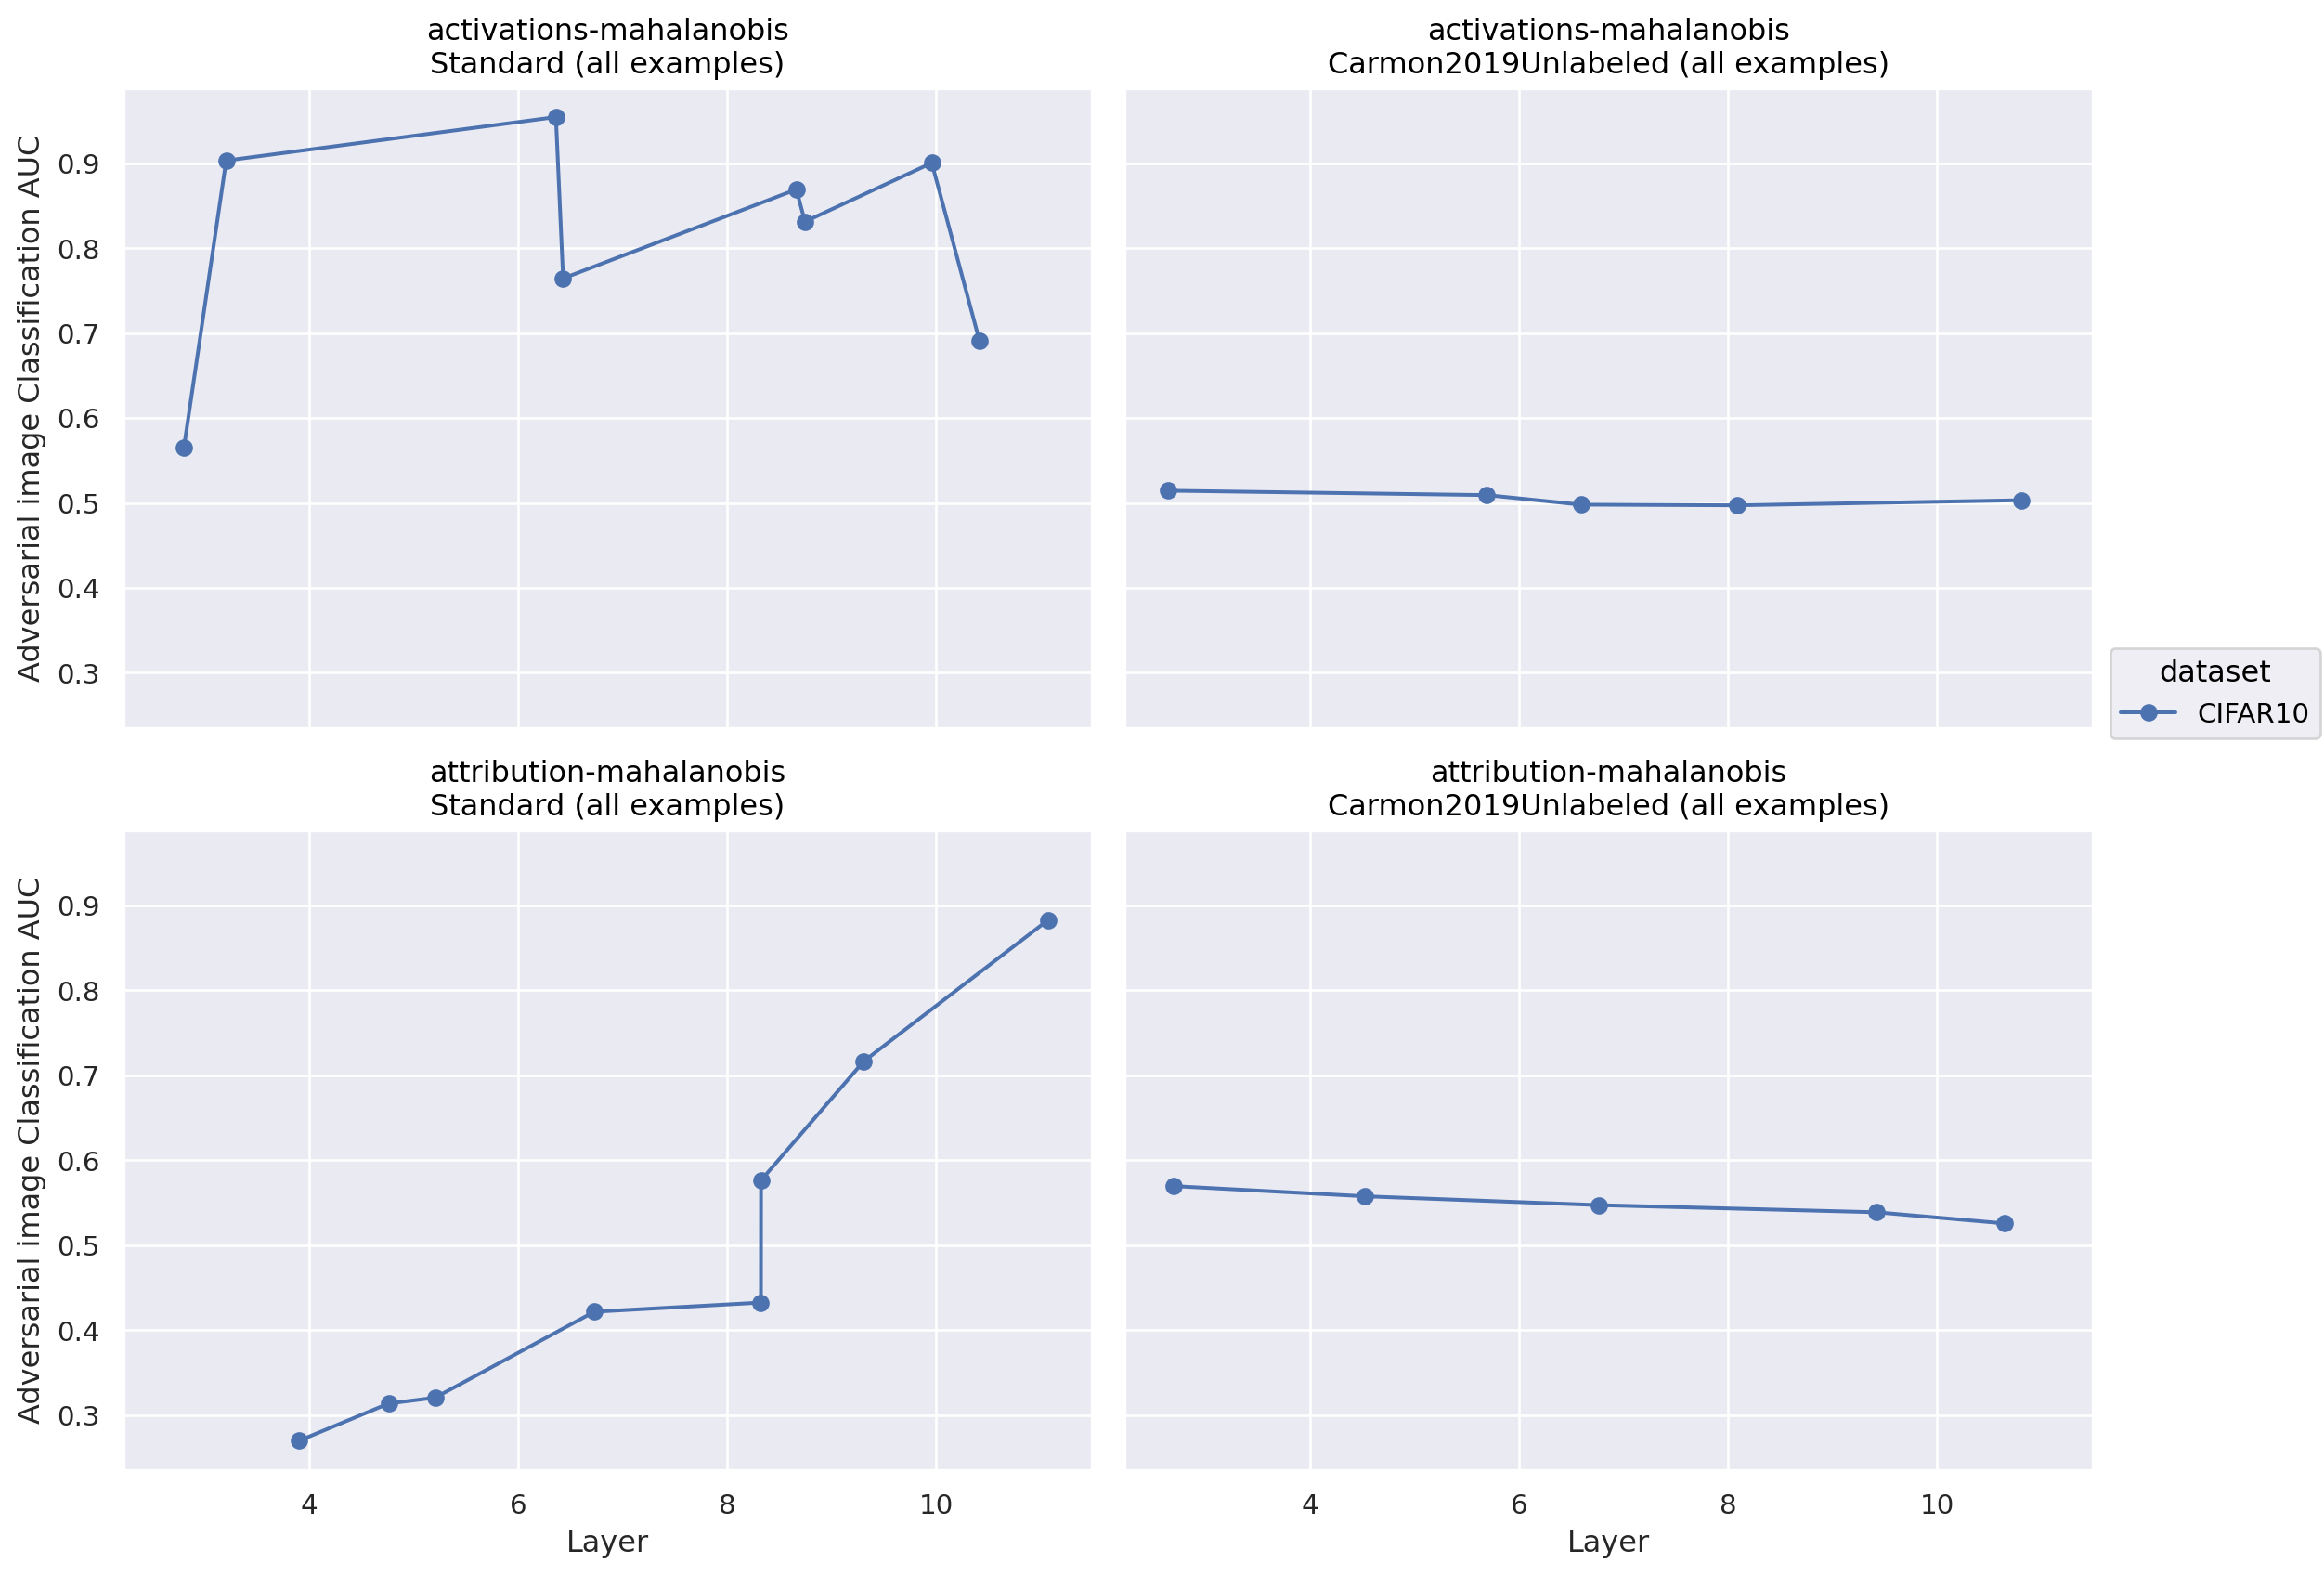

In [260]:
df_image = get_data(filters['none'], log_dir=image_dir) 
df_image['dataset'] = 'CIFAR10'
plot_auc_roc_by_layer_by_score(df_image)

In [229]:
df_image

alpha dataset                    score     features  layer  random_names  \
0     NaN     NaN  activations-mahalanobis  activations      1             1   
2     NaN     NaN  activations-mahalanobis  activations      2             1   
4     NaN     NaN  activations-mahalanobis  activations      3             1   
14    NaN     NaN    activations-isoforest  activations      1             1   
17    NaN     NaN    activations-isoforest  activations      2             1   
19    NaN     NaN    activations-isoforest  activations      3             1   
22    8.0     NaN                      NaN  activations      1             1   
25    8.0     NaN                      NaN  activations      2             1   
27    8.0     NaN                      NaN  activations      3             1   
44   20.0     NaN          activations-lof  activations      1             1   
46   20.0     NaN          activations-lof  activations      2             1   
48   20.0     NaN          activations-lof  activations      3             1   

    auc_roc  auc_roc_agree  auc_roc_disagree  
0    0.5144            0.5            0.5144  
2    0.4980            0.5            0.4980  
4    0.5032            0.5            0.5032  
14   0.5108            0.5            0.5108  
17   0.6704            0.5            0.6704  
19   0.8128            0.5            0.8128  
22   0.7420            0.5            0.7420  
25   0.7552            0.5            0.7552  
27   0.8224            0.5            0.8224  
44   0.5030            0.5            0.5030  
46   0.4974            0.5            0.4974  
48   0.5042            0.5            0.5042

In [145]:
df_all[df_all['features']=='iterative_rephrase']

alpha          dataset     score            features  layer  \
166     NaN             sciq  rephrase  iterative_rephrase     -1   
275     NaN  modularaddition  rephrase  iterative_rephrase     -1   
1022    NaN   multiplication  rephrase  iterative_rephrase     -1   
1590    NaN       hemisphere  rephrase  iterative_rephrase     -1   
1767    NaN              nli  rephrase  iterative_rephrase     -1   
1960    NaN        sentiment  rephrase  iterative_rephrase     -1   
2099    NaN      subtraction  rephrase  iterative_rephrase     -1   
2242    NaN         addition  rephrase  iterative_rephrase     -1   
2705    NaN       population  rephrase  iterative_rephrase     -1   

      random_names   auc_roc  auc_roc_agree  auc_roc_disagree  
166              1  0.405154       0.299627          0.199413  
275              1  0.590873       0.594124          0.586586  
1022             1  0.576329       0.630132          0.528508  
1590             1  0.426465       0.518558          0.294000  
1767             1  0.532087       0.382376          0.898589  
1960             1  0.298001       0.299332          0.245995  
2099             1  0.496183       0.476595          0.512407  
2242             1  0.544217       0.356189          0.523831  
2705             1  0.680552       0.783697          0.513108